In [1]:
NAME = "Dustin Seltz"

Purpose:

This aims to answer Question 4: Taking into account the student’s progress and goals, what is the best set of 
kanji / vocab to teach to them next?

This file aims to use the frequency information regarding Twitter, News, Wikipedia, and Aozora (from https://scriptin.github.io/kanji-frequency/ ) and compare it to the difficulty levels and frequency from WaniKani, JLPT, Grade, and Genki in order to tell a user (who wants to learn how to read one Twitter or News or Wikipedia or Aozora) the optimal sequence to follow in learning Kanji. 

This file also contains some queries Oleksandra requested. Given that you have completed a certain level from a sequence (ex: "N1" from JLPT, "grade 6" from school, or level "50" from WaniKani) what are the next kanji you should learn?

Input:

new_combined_genki.csv 
This file contains information for the 2136 Jōyō kanji. This program uses the difficulty levels and frequency information. 

Output:

Tells the user which learning sequence should be used to quickly learn each of the fours datasources. Currently only inline output, no csv. 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from numpy import isnan

In [28]:
##filename = "combined_genki_lessons.csv"
#filename = "new_combined_genki.csv"
filename = "../Question1/cleaned_link.csv"
df = pd.read_csv(filename)
print(len(df))
df.head()
#Index and Unnamed: 0 are the Joyo ranking. 
#When using the Joyo ranking I use the Unnamed: 0 as the column, so the index should be irrelevant to this program. 
#TODO: maybe just remove Joyo analysis, not really relevant. 

2136


,Unnamed: 0,Unnamed: 0.1,kanji,strokes,frequency,grade,jlpt,parts,radicals,on_readings,...,Number of Appearances on Wikipedia,Percentage of Appearances on Wikipedia,Rank of Appearances on Wikipedia,Number of Appearances on News,Percentage of Appearances on News,Rank of Appearances on News,Number of Appearances on Aozora,Percentage of Appearances on Aozora,Rank of Appearances on Aozora,Genki_Lesson
0,0,0,亜,7.0,1509.0,junior high,N1,"['一', '｜', '口']",{'二': 'two'},['ア'],...,172858.0,0.000220,836.0,689.0,0.000067,1306.0,3506.0,0.000068,1710.0,NaN
1,1,1,哀,9.0,1715.0,junior high,N1,"['亠', '口', '衣']","{'口': 'mouth, opening'}",['アイ'],...,19390.0,0.000025,1884.0,167.0,0.000016,1842.0,10141.0,0.000197,971.0,NaN
2,2,2,挨,10.0,2258.0,junior high,NaN,"['厶', '扎', '矢', '乞']",{'手 (扌龵)': 'hand'},['アイ'],...,12111.0,0.000015,2138.0,13.0,0.000001,2634.0,6784.0,0.000132,1249.0,NaN
3,3,3,愛,13.0,640.0,grade 4,N3,"['冖', '夂', '心', '爪']","{'心 (忄, ⺗)': 'heart'}",['アイ'],...,754387.0,0.000962,269.0,5340.0,0.000518,503.0,54392.0,0.001057,213.0,NaN
4,4,4,曖,17.0,NaN,junior high,NaN,"['冖', '夂', '心', '日', '爪']","{'日': 'sun, day'}",['アイ'],...,116055.0,0.000148,1025.0,30.0,0.000003,2371.0,1001.0,0.000019,2661.0,NaN


In [4]:
datasources = ["Twitter", "Aozora", "Wikipedia", "News"]
kanjis = df["kanji"]

In [5]:
def createBins(numberOfBins, col):
    #Create a sorted version of the column. #No, that'll ruin the ordering
    #arr = []
    #for value in col:
    #    arr.append(value)
    #arr.sort()
    
    #qcut to get bin numbers for the column. 
    #    Each column's kanji now has a numeric level equivalent based on frequency. 
    #    This will allow us to compare bins, like N5 through N1 vs bins 1 through 5. 
    bins = pd.qcut(col, numberOfBins, labels=False)
    #Lets not start at 0, levels start at 1 for everything. 
    bins += 1
    print("Created bin column:", bins)
    print("Using ranges ", pd.qcut(col, numberOfBins))
    return bins

In [6]:
#Col name should be the col of the dataframe with the levels, 
#    translator translates those level strings to integer levels from 1..max_level, inclusive, 
#        Ex: "N5" translator should say is 1, while "N1" should be 5. (lowest to highest difficulty)
#    max_level is how many levels, like 60 for WaniKani's 1..60 system, or 5 for JLPT. 
def getAvgLevelDiff(level_col_name, translator, max_level):
    results = []
    for sourceName in datasources:
        bins = createBins(max_level, df["Rank of Appearances on "+sourceName])
        rankLevel_col = pd.DataFrame(bins)
        rankLevel_col.columns = ["Rank Converted to Level"]
        new_df = df.join(rankLevel_col)
        numberOfComparisons = 0
        numberOfLevelDifference = 0
        for kanji in kanjis:
            row = new_df[kanjis == kanji].iloc[0]
            colValue = row[level_col_name]
            #We need a numeric representation of the level, which our caller will define
            colLevel = translator(colValue)
            #We then separate into bins for comparison. 
            #Then take the average of ("level" (bin) number compared with the actual level)
            rankLevel = row["Rank Converted to Level"]
            diff = abs(colLevel - rankLevel)
            if(not isnan(diff)):
                numberOfComparisons += 1
                numberOfLevelDifference += diff
                print(kanji+": level "+str(colValue)+" translated to "+str(colLevel)+" and corresponds to rank " 
                      +str(rankLevel)+" with a diff of abs(level - rank)="+str(diff))
        averageLevelDifference = numberOfLevelDifference / numberOfComparisons
        results.append(averageLevelDifference)
        print(sourceName+" vs "+level_col_name+" average level difference="+str(averageLevelDifference))
    return results

In [7]:
#How strongly does WaniKani level corrolate with each source?
#WaniKani levels range from 1 to 60, with higher being harder (or rather, learned later. Harder or more obscure). 
intIsJustItself = lambda x: x
wani_levels = 60
wani_results = getAvgLevelDiff("wanikani_level", intIsJustItself, wani_levels)

Created bin column: 0       38.0
1       36.0
2       36.0
3        2.0
4       52.0
5        4.0
6       30.0
7       26.0
8       35.0
9       54.0
10      35.0
11       5.0
12      19.0
13      28.0
14       7.0
15      25.0
16       7.0
17      24.0
18      24.0
19      38.0
20      36.0
21      43.0
22      21.0
23      59.0
24      31.0
25      58.0
26      25.0
27      22.0
28      24.0
29      36.0
        ... 
2106    53.0
2107    10.0
2108    53.0
2109    14.0
2110    53.0
2111    57.0
2112    13.0
2113    35.0
2114    24.0
2115    25.0
2116    51.0
2117    15.0
2118    43.0
2119    30.0
2120    47.0
2121    52.0
2122    38.0
2123    49.0
2124    22.0
2125    16.0
2126    57.0
2127    19.0
2128     8.0
2129     2.0
2130    51.0
2131    38.0
2132    21.0
2133    37.0
2134    36.0
2135    27.0
Name: Rank of Appearances on Twitter, Length: 2136, dtype: float64
Using ranges  0       (1364.883, 1401.367]
1         (1285.917, 1326.4]
2         (1285.917, 1326.4]
3           (36.483

営: level 22.0 translated to 22.0 and corresponds to rank 16.0 with a diff of abs(level - rank)=6.0
詠: level 59.0 translated to 59.0 and corresponds to rank 57.0 with a diff of abs(level - rank)=2.0
影: level 25.0 translated to 25.0 and corresponds to rank 16.0 with a diff of abs(level - rank)=9.0
鋭: level 40.0 translated to 40.0 and corresponds to rank 53.0 with a diff of abs(level - rank)=13.0
衛: level 32.0 translated to 32.0 and corresponds to rank 25.0 with a diff of abs(level - rank)=7.0
易: level 19.0 translated to 19.0 and corresponds to rank 41.0 with a diff of abs(level - rank)=22.0
疫: level 50.0 translated to 50.0 and corresponds to rank 53.0 with a diff of abs(level - rank)=3.0
益: level 28.0 translated to 28.0 and corresponds to rank 40.0 with a diff of abs(level - rank)=12.0
液: level 32.0 translated to 32.0 and corresponds to rank 39.0 with a diff of abs(level - rank)=7.0
駅: level 13.0 translated to 13.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=12.0
悦: leve

解: level 21.0 translated to 21.0 and corresponds to rank 9.0 with a diff of abs(level - rank)=12.0
壊: level 29.0 translated to 29.0 and corresponds to rank 19.0 with a diff of abs(level - rank)=10.0
懐: level 30.0 translated to 30.0 and corresponds to rank 17.0 with a diff of abs(level - rank)=13.0
貝: level 4.0 translated to 4.0 and corresponds to rank 44.0 with a diff of abs(level - rank)=40.0
外: level 3.0 translated to 3.0 and corresponds to rank 5.0 with a diff of abs(level - rank)=2.0
劾: level 60.0 translated to 60.0 and corresponds to rank 60.0 with a diff of abs(level - rank)=0.0
害: level 20.0 translated to 20.0 and corresponds to rank 21.0 with a diff of abs(level - rank)=1.0
崖: level 47.0 translated to 47.0 and corresponds to rank 55.0 with a diff of abs(level - rank)=8.0
涯: level 50.0 translated to 50.0 and corresponds to rank 52.0 with a diff of abs(level - rank)=2.0
街: level 29.0 translated to 29.0 and corresponds to rank 20.0 with a diff of abs(level - rank)=9.0
慨: level 58.

去: level 4.0 translated to 4.0 and corresponds to rank 17.0 with a diff of abs(level - rank)=13.0
巨: level 28.0 translated to 28.0 and corresponds to rank 27.0 with a diff of abs(level - rank)=1.0
居: level 25.0 translated to 25.0 and corresponds to rank 11.0 with a diff of abs(level - rank)=14.0
拒: level 39.0 translated to 39.0 and corresponds to rank 42.0 with a diff of abs(level - rank)=3.0
拠: level 41.0 translated to 41.0 and corresponds to rank 38.0 with a diff of abs(level - rank)=3.0
挙: level 21.0 translated to 21.0 and corresponds to rank 21.0 with a diff of abs(level - rank)=0.0
虚: level 17.0 translated to 17.0 and corresponds to rank 42.0 with a diff of abs(level - rank)=25.0
許: level 18.0 translated to 18.0 and corresponds to rank 16.0 with a diff of abs(level - rank)=2.0
距: level 43.0 translated to 43.0 and corresponds to rank 32.0 with a diff of abs(level - rank)=11.0
魚: level 7.0 translated to 7.0 and corresponds to rank 23.0 with a diff of abs(level - rank)=16.0
御: level 

拘: level 49.0 translated to 49.0 and corresponds to rank 50.0 with a diff of abs(level - rank)=1.0
肯: level 51.0 translated to 51.0 and corresponds to rank 56.0 with a diff of abs(level - rank)=5.0
厚: level 20.0 translated to 20.0 and corresponds to rank 26.0 with a diff of abs(level - rank)=6.0
恒: level 52.0 translated to 52.0 and corresponds to rank 43.0 with a diff of abs(level - rank)=9.0
洪: level 56.0 translated to 56.0 and corresponds to rank 41.0 with a diff of abs(level - rank)=15.0
皇: level 33.0 translated to 33.0 and corresponds to rank 38.0 with a diff of abs(level - rank)=5.0
紅: level 34.0 translated to 34.0 and corresponds to rank 34.0 with a diff of abs(level - rank)=0.0
荒: level 42.0 translated to 42.0 and corresponds to rank 22.0 with a diff of abs(level - rank)=20.0
郊: level 51.0 translated to 51.0 and corresponds to rank 56.0 with a diff of abs(level - rank)=5.0
香: level 37.0 translated to 37.0 and corresponds to rank 16.0 with a diff of abs(level - rank)=21.0
候: leve

諮: level 50.0 translated to 50.0 and corresponds to rank 60.0 with a diff of abs(level - rank)=10.0
示: level 22.0 translated to 22.0 and corresponds to rank 24.0 with a diff of abs(level - rank)=2.0
字: level 4.0 translated to 4.0 and corresponds to rank 16.0 with a diff of abs(level - rank)=12.0
寺: level 15.0 translated to 15.0 and corresponds to rank 14.0 with a diff of abs(level - rank)=1.0
次: level 6.0 translated to 6.0 and corresponds to rank 6.0 with a diff of abs(level - rank)=0.0
耳: level 4.0 translated to 4.0 and corresponds to rank 25.0 with a diff of abs(level - rank)=21.0
自: level 5.0 translated to 5.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=3.0
似: level 31.0 translated to 31.0 and corresponds to rank 12.0 with a diff of abs(level - rank)=19.0
児: level 28.0 translated to 28.0 and corresponds to rank 21.0 with a diff of abs(level - rank)=7.0
事: level 9.0 translated to 9.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=8.0
侍: level 44.0 trans

訟: level 25.0 translated to 25.0 and corresponds to rank 54.0 with a diff of abs(level - rank)=29.0
勝: level 9.0 translated to 9.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=5.0
掌: level 47.0 translated to 47.0 and corresponds to rank 51.0 with a diff of abs(level - rank)=4.0
晶: level 50.0 translated to 50.0 and corresponds to rank 48.0 with a diff of abs(level - rank)=2.0
焼: level 18.0 translated to 18.0 and corresponds to rank 8.0 with a diff of abs(level - rank)=10.0
焦: level 42.0 translated to 42.0 and corresponds to rank 26.0 with a diff of abs(level - rank)=16.0
粧: level 47.0 translated to 47.0 and corresponds to rank 34.0 with a diff of abs(level - rank)=13.0
証: level 16.0 translated to 16.0 and corresponds to rank 26.0 with a diff of abs(level - rank)=10.0
象: level 24.0 translated to 24.0 and corresponds to rank 8.0 with a diff of abs(level - rank)=16.0
傷: level 32.0 translated to 32.0 and corresponds to rank 27.0 with a diff of abs(level - rank)=5.0
奨: level 

体: level 5.0 translated to 5.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
耐: level 48.0 translated to 48.0 and corresponds to rank 33.0 with a diff of abs(level - rank)=15.0
待: level 12.0 translated to 12.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=8.0
怠: level 52.0 translated to 52.0 and corresponds to rank 44.0 with a diff of abs(level - rank)=8.0
胎: level 57.0 translated to 57.0 and corresponds to rank 57.0 with a diff of abs(level - rank)=0.0
退: level 27.0 translated to 27.0 and corresponds to rank 19.0 with a diff of abs(level - rank)=8.0
帯: level 31.0 translated to 31.0 and corresponds to rank 14.0 with a diff of abs(level - rank)=17.0
泰: level 43.0 translated to 43.0 and corresponds to rank 49.0 with a diff of abs(level - rank)=6.0
袋: level 42.0 translated to 42.0 and corresponds to rank 17.0 with a diff of abs(level - rank)=25.0
逮: level 25.0 translated to 25.0 and corresponds to rank 44.0 with a diff of abs(level - rank)=19.0
替: level 2

展: level 24.0 translated to 24.0 and corresponds to rank 19.0 with a diff of abs(level - rank)=5.0
添: level 29.0 translated to 29.0 and corresponds to rank 37.0 with a diff of abs(level - rank)=8.0
転: level 10.0 translated to 10.0 and corresponds to rank 9.0 with a diff of abs(level - rank)=1.0
田: level 2.0 translated to 2.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
伝: level 11.0 translated to 11.0 and corresponds to rank 13.0 with a diff of abs(level - rank)=2.0
殿: level 40.0 translated to 40.0 and corresponds to rank 33.0 with a diff of abs(level - rank)=7.0
電: level 8.0 translated to 8.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=5.0
斗: level 44.0 translated to 44.0 and corresponds to rank 34.0 with a diff of abs(level - rank)=10.0
吐: level 34.0 translated to 34.0 and corresponds to rank 23.0 with a diff of abs(level - rank)=11.0
徒: level 19.0 translated to 19.0 and corresponds to rank 30.0 with a diff of abs(level - rank)=11.0
途: level 27.0 

飯: level 15.0 translated to 15.0 and corresponds to rank 6.0 with a diff of abs(level - rank)=9.0
搬: level 50.0 translated to 50.0 and corresponds to rank 52.0 with a diff of abs(level - rank)=2.0
煩: level 60.0 translated to 60.0 and corresponds to rank 54.0 with a diff of abs(level - rank)=6.0
範: level 42.0 translated to 42.0 and corresponds to rank 39.0 with a diff of abs(level - rank)=3.0
繁: level 40.0 translated to 40.0 and corresponds to rank 45.0 with a diff of abs(level - rank)=5.0
藩: level 58.0 translated to 58.0 and corresponds to rank 56.0 with a diff of abs(level - rank)=2.0
晩: level 15.0 translated to 15.0 and corresponds to rank 22.0 with a diff of abs(level - rank)=7.0
番: level 8.0 translated to 8.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=4.0
蛮: level 60.0 translated to 60.0 and corresponds to rank 50.0 with a diff of abs(level - rank)=10.0
盤: level 38.0 translated to 38.0 and corresponds to rank 32.0 with a diff of abs(level - rank)=6.0
比: level 19.0

某: level 60.0 translated to 60.0 and corresponds to rank 38.0 with a diff of abs(level - rank)=22.0
冒: level 16.0 translated to 16.0 and corresponds to rank 47.0 with a diff of abs(level - rank)=31.0
剖: level 58.0 translated to 58.0 and corresponds to rank 54.0 with a diff of abs(level - rank)=4.0
紡: level 59.0 translated to 59.0 and corresponds to rank 58.0 with a diff of abs(level - rank)=1.0
望: level 14.0 translated to 14.0 and corresponds to rank 14.0 with a diff of abs(level - rank)=0.0
傍: level 55.0 translated to 55.0 and corresponds to rank 53.0 with a diff of abs(level - rank)=2.0
帽: level 47.0 translated to 47.0 and corresponds to rank 37.0 with a diff of abs(level - rank)=10.0
棒: level 31.0 translated to 31.0 and corresponds to rank 31.0 with a diff of abs(level - rank)=0.0
貿: level 36.0 translated to 36.0 and corresponds to rank 57.0 with a diff of abs(level - rank)=21.0
暴: level 19.0 translated to 19.0 and corresponds to rank 24.0 with a diff of abs(level - rank)=5.0
膨: lev

謡: level 54.0 translated to 54.0 and corresponds to rank 49.0 with a diff of abs(level - rank)=5.0
曜: level 16.0 translated to 16.0 and corresponds to rank 5.0 with a diff of abs(level - rank)=11.0
抑: level 38.0 translated to 38.0 and corresponds to rank 37.0 with a diff of abs(level - rank)=1.0
浴: level 16.0 translated to 16.0 and corresponds to rank 28.0 with a diff of abs(level - rank)=12.0
欲: level 32.0 translated to 32.0 and corresponds to rank 7.0 with a diff of abs(level - rank)=25.0
翌: level 30.0 translated to 30.0 and corresponds to rank 46.0 with a diff of abs(level - rank)=16.0
翼: level 44.0 translated to 44.0 and corresponds to rank 41.0 with a diff of abs(level - rank)=3.0
裸: level 45.0 translated to 45.0 and corresponds to rank 38.0 with a diff of abs(level - rank)=7.0
羅: level 57.0 translated to 57.0 and corresponds to rank 32.0 with a diff of abs(level - rank)=25.0
来: level 5.0 translated to 5.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=4.0
雷: level 4

亜: level 59.0 translated to 59.0 and corresponds to rank 44.0 with a diff of abs(level - rank)=15.0
哀: level 47.0 translated to 47.0 and corresponds to rank 27.0 with a diff of abs(level - rank)=20.0
挨: level 44.0 translated to 44.0 and corresponds to rank 34.0 with a diff of abs(level - rank)=10.0
愛: level 17.0 translated to 17.0 and corresponds to rank 6.0 with a diff of abs(level - rank)=11.0
悪: level 12.0 translated to 12.0 and corresponds to rank 6.0 with a diff of abs(level - rank)=6.0
握: level 42.0 translated to 42.0 and corresponds to rank 27.0 with a diff of abs(level - rank)=15.0
圧: level 20.0 translated to 20.0 and corresponds to rank 32.0 with a diff of abs(level - rank)=12.0
扱: level 38.0 translated to 38.0 and corresponds to rank 33.0 with a diff of abs(level - rank)=5.0
嵐: level 44.0 translated to 44.0 and corresponds to rank 48.0 with a diff of abs(level - rank)=4.0
安: level 6.0 translated to 6.0 and corresponds to rank 7.0 with a diff of abs(level - rank)=1.0
案: level 

拡: level 33.0 translated to 33.0 and corresponds to rank 39.0 with a diff of abs(level - rank)=6.0
革: level 23.0 translated to 23.0 and corresponds to rank 31.0 with a diff of abs(level - rank)=8.0
格: level 14.0 translated to 14.0 and corresponds to rank 13.0 with a diff of abs(level - rank)=1.0
核: level 36.0 translated to 36.0 and corresponds to rank 54.0 with a diff of abs(level - rank)=18.0
殻: level 58.0 translated to 58.0 and corresponds to rank 51.0 with a diff of abs(level - rank)=7.0
郭: level 55.0 translated to 55.0 and corresponds to rank 54.0 with a diff of abs(level - rank)=1.0
覚: level 17.0 translated to 17.0 and corresponds to rank 8.0 with a diff of abs(level - rank)=9.0
較: level 26.0 translated to 26.0 and corresponds to rank 35.0 with a diff of abs(level - rank)=9.0
隔: level 49.0 translated to 49.0 and corresponds to rank 40.0 with a diff of abs(level - rank)=9.0
閣: level 29.0 translated to 29.0 and corresponds to rank 34.0 with a diff of abs(level - rank)=5.0
確: level 2

急: level 16.0 translated to 16.0 and corresponds to rank 9.0 with a diff of abs(level - rank)=7.0
級: level 11.0 translated to 11.0 and corresponds to rank 26.0 with a diff of abs(level - rank)=15.0
糾: level 42.0 translated to 42.0 and corresponds to rank 59.0 with a diff of abs(level - rank)=17.0
宮: level 22.0 translated to 22.0 and corresponds to rank 11.0 with a diff of abs(level - rank)=11.0
救: level 31.0 translated to 31.0 and corresponds to rank 29.0 with a diff of abs(level - rank)=2.0
球: level 12.0 translated to 12.0 and corresponds to rank 31.0 with a diff of abs(level - rank)=19.0
給: level 27.0 translated to 27.0 and corresponds to rank 20.0 with a diff of abs(level - rank)=7.0
窮: level 56.0 translated to 56.0 and corresponds to rank 39.0 with a diff of abs(level - rank)=17.0
牛: level 3.0 translated to 3.0 and corresponds to rank 23.0 with a diff of abs(level - rank)=20.0
去: level 4.0 translated to 4.0 and corresponds to rank 11.0 with a diff of abs(level - rank)=7.0
巨: level 

剣: level 35.0 translated to 35.0 and corresponds to rank 27.0 with a diff of abs(level - rank)=8.0
拳: level 41.0 translated to 41.0 and corresponds to rank 47.0 with a diff of abs(level - rank)=6.0
軒: level 51.0 translated to 51.0 and corresponds to rank 22.0 with a diff of abs(level - rank)=29.0
健: level 27.0 translated to 27.0 and corresponds to rank 26.0 with a diff of abs(level - rank)=1.0
険: level 16.0 translated to 16.0 and corresponds to rank 30.0 with a diff of abs(level - rank)=14.0
圏: level 39.0 translated to 39.0 and corresponds to rank 44.0 with a diff of abs(level - rank)=5.0
堅: level 42.0 translated to 42.0 and corresponds to rank 35.0 with a diff of abs(level - rank)=7.0
検: level 21.0 translated to 21.0 and corresponds to rank 29.0 with a diff of abs(level - rank)=8.0
嫌: level 20.0 translated to 20.0 and corresponds to rank 20.0 with a diff of abs(level - rank)=0.0
献: level 36.0 translated to 36.0 and corresponds to rank 42.0 with a diff of abs(level - rank)=6.0
絹: level

採: level 32.0 translated to 32.0 and corresponds to rank 39.0 with a diff of abs(level - rank)=7.0
済: level 21.0 translated to 21.0 and corresponds to rank 19.0 with a diff of abs(level - rank)=2.0
祭: level 12.0 translated to 12.0 and corresponds to rank 27.0 with a diff of abs(level - rank)=15.0
斎: level 42.0 translated to 42.0 and corresponds to rank 27.0 with a diff of abs(level - rank)=15.0
細: level 17.0 translated to 17.0 and corresponds to rank 10.0 with a diff of abs(level - rank)=7.0
菜: level 31.0 translated to 31.0 and corresponds to rank 38.0 with a diff of abs(level - rank)=7.0
最: level 10.0 translated to 10.0 and corresponds to rank 5.0 with a diff of abs(level - rank)=5.0
裁: level 23.0 translated to 23.0 and corresponds to rank 33.0 with a diff of abs(level - rank)=10.0
債: level 36.0 translated to 36.0 and corresponds to rank 56.0 with a diff of abs(level - rank)=20.0
催: level 29.0 translated to 29.0 and corresponds to rank 41.0 with a diff of abs(level - rank)=12.0
歳: lev

朱: level 44.0 translated to 44.0 and corresponds to rank 43.0 with a diff of abs(level - rank)=1.0
取: level 16.0 translated to 16.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=13.0
狩: level 45.0 translated to 45.0 and corresponds to rank 47.0 with a diff of abs(level - rank)=2.0
首: level 6.0 translated to 6.0 and corresponds to rank 11.0 with a diff of abs(level - rank)=5.0
殊: level 52.0 translated to 52.0 and corresponds to rank 24.0 with a diff of abs(level - rank)=28.0
珠: level 49.0 translated to 49.0 and corresponds to rank 42.0 with a diff of abs(level - rank)=7.0
酒: level 10.0 translated to 10.0 and corresponds to rank 10.0 with a diff of abs(level - rank)=0.0
種: level 18.0 translated to 18.0 and corresponds to rank 8.0 with a diff of abs(level - rank)=10.0
趣: level 43.0 translated to 43.0 and corresponds to rank 27.0 with a diff of abs(level - rank)=16.0
寿: level 35.0 translated to 35.0 and corresponds to rank 38.0 with a diff of abs(level - rank)=3.0
受: level 9

甚: level 59.0 translated to 59.0 and corresponds to rank 23.0 with a diff of abs(level - rank)=36.0
陣: level 37.0 translated to 37.0 and corresponds to rank 28.0 with a diff of abs(level - rank)=9.0
尋: level 31.0 translated to 31.0 and corresponds to rank 25.0 with a diff of abs(level - rank)=6.0
須: level 52.0 translated to 52.0 and corresponds to rank 38.0 with a diff of abs(level - rank)=14.0
図: level 5.0 translated to 5.0 and corresponds to rank 9.0 with a diff of abs(level - rank)=4.0
水: level 2.0 translated to 2.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
吹: level 40.0 translated to 40.0 and corresponds to rank 15.0 with a diff of abs(level - rank)=25.0
垂: level 33.0 translated to 33.0 and corresponds to rank 32.0 with a diff of abs(level - rank)=1.0
炊: level 47.0 translated to 47.0 and corresponds to rank 52.0 with a diff of abs(level - rank)=5.0
帥: level 53.0 translated to 53.0 and corresponds to rank 58.0 with a diff of abs(level - rank)=5.0
粋: level 34.0

操: level 33.0 translated to 33.0 and corresponds to rank 32.0 with a diff of abs(level - rank)=1.0
燥: level 51.0 translated to 51.0 and corresponds to rank 55.0 with a diff of abs(level - rank)=4.0
霜: level 48.0 translated to 48.0 and corresponds to rank 44.0 with a diff of abs(level - rank)=4.0
騒: level 30.0 translated to 30.0 and corresponds to rank 23.0 with a diff of abs(level - rank)=7.0
藻: level 60.0 translated to 60.0 and corresponds to rank 49.0 with a diff of abs(level - rank)=11.0
造: level 26.0 translated to 26.0 and corresponds to rank 13.0 with a diff of abs(level - rank)=13.0
像: level 13.0 translated to 13.0 and corresponds to rank 14.0 with a diff of abs(level - rank)=1.0
増: level 21.0 translated to 21.0 and corresponds to rank 24.0 with a diff of abs(level - rank)=3.0
憎: level 47.0 translated to 47.0 and corresponds to rank 28.0 with a diff of abs(level - rank)=19.0
蔵: level 33.0 translated to 33.0 and corresponds to rank 12.0 with a diff of abs(level - rank)=21.0
贈: lev

腸: level 57.0 translated to 57.0 and corresponds to rank 52.0 with a diff of abs(level - rank)=5.0
跳: level 37.0 translated to 37.0 and corresponds to rank 44.0 with a diff of abs(level - rank)=7.0
徴: level 26.0 translated to 26.0 and corresponds to rank 36.0 with a diff of abs(level - rank)=10.0
潮: level 43.0 translated to 43.0 and corresponds to rank 32.0 with a diff of abs(level - rank)=11.0
澄: level 45.0 translated to 45.0 and corresponds to rank 33.0 with a diff of abs(level - rank)=12.0
調: level 10.0 translated to 10.0 and corresponds to rank 8.0 with a diff of abs(level - rank)=2.0
聴: level 37.0 translated to 37.0 and corresponds to rank 23.0 with a diff of abs(level - rank)=14.0
懲: level 43.0 translated to 43.0 and corresponds to rank 54.0 with a diff of abs(level - rank)=11.0
直: level 6.0 translated to 6.0 and corresponds to rank 5.0 with a diff of abs(level - rank)=1.0
沈: level 43.0 translated to 43.0 and corresponds to rank 22.0 with a diff of abs(level - rank)=21.0
珍: level

虹: level 47.0 translated to 47.0 and corresponds to rank 54.0 with a diff of abs(level - rank)=7.0
日: level 2.0 translated to 2.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
入: level 1.0 translated to 1.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
乳: level 23.0 translated to 23.0 and corresponds to rank 31.0 with a diff of abs(level - rank)=8.0
尿: level 55.0 translated to 55.0 and corresponds to rank 58.0 with a diff of abs(level - rank)=3.0
任: level 21.0 translated to 21.0 and corresponds to rank 21.0 with a diff of abs(level - rank)=0.0
妊: level 38.0 translated to 38.0 and corresponds to rank 58.0 with a diff of abs(level - rank)=20.0
忍: level 44.0 translated to 44.0 and corresponds to rank 26.0 with a diff of abs(level - rank)=18.0
認: level 21.0 translated to 21.0 and corresponds to rank 17.0 with a diff of abs(level - rank)=4.0
寧: level 46.0 translated to 46.0 and corresponds to rank 32.0 with a diff of abs(level - rank)=14.0
熱: level 13.0

婦: level 28.0 translated to 28.0 and corresponds to rank 10.0 with a diff of abs(level - rank)=18.0
符: level 30.0 translated to 30.0 and corresponds to rank 39.0 with a diff of abs(level - rank)=9.0
富: level 31.0 translated to 31.0 and corresponds to rank 19.0 with a diff of abs(level - rank)=12.0
普: level 31.0 translated to 31.0 and corresponds to rank 23.0 with a diff of abs(level - rank)=8.0
腐: level 34.0 translated to 34.0 and corresponds to rank 38.0 with a diff of abs(level - rank)=4.0
敷: level 40.0 translated to 40.0 and corresponds to rank 12.0 with a diff of abs(level - rank)=28.0
膚: level 51.0 translated to 51.0 and corresponds to rank 45.0 with a diff of abs(level - rank)=6.0
譜: level 58.0 translated to 58.0 and corresponds to rank 54.0 with a diff of abs(level - rank)=4.0
侮: level 59.0 translated to 59.0 and corresponds to rank 49.0 with a diff of abs(level - rank)=10.0
武: level 24.0 translated to 24.0 and corresponds to rank 10.0 with a diff of abs(level - rank)=14.0
部: le

肪: level 51.0 translated to 51.0 and corresponds to rank 58.0 with a diff of abs(level - rank)=7.0
某: level 60.0 translated to 60.0 and corresponds to rank 40.0 with a diff of abs(level - rank)=20.0
冒: level 16.0 translated to 16.0 and corresponds to rank 46.0 with a diff of abs(level - rank)=30.0
剖: level 58.0 translated to 58.0 and corresponds to rank 54.0 with a diff of abs(level - rank)=4.0
紡: level 59.0 translated to 59.0 and corresponds to rank 59.0 with a diff of abs(level - rank)=0.0
望: level 14.0 translated to 14.0 and corresponds to rank 11.0 with a diff of abs(level - rank)=3.0
傍: level 55.0 translated to 55.0 and corresponds to rank 15.0 with a diff of abs(level - rank)=40.0
帽: level 47.0 translated to 47.0 and corresponds to rank 30.0 with a diff of abs(level - rank)=17.0
棒: level 31.0 translated to 31.0 and corresponds to rank 27.0 with a diff of abs(level - rank)=4.0
貿: level 36.0 translated to 36.0 and corresponds to rank 56.0 with a diff of abs(level - rank)=20.0
暴: le

璃: level 58.0 translated to 58.0 and corresponds to rank 46.0 with a diff of abs(level - rank)=12.0
離: level 31.0 translated to 31.0 and corresponds to rank 12.0 with a diff of abs(level - rank)=19.0
陸: level 31.0 translated to 31.0 and corresponds to rank 28.0 with a diff of abs(level - rank)=3.0
立: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
律: level 23.0 translated to 23.0 and corresponds to rank 31.0 with a diff of abs(level - rank)=8.0
略: level 29.0 translated to 29.0 and corresponds to rank 33.0 with a diff of abs(level - rank)=4.0
柳: level 47.0 translated to 47.0 and corresponds to rank 26.0 with a diff of abs(level - rank)=21.0
流: level 12.0 translated to 12.0 and corresponds to rank 6.0 with a diff of abs(level - rank)=6.0
留: level 16.0 translated to 16.0 and corresponds to rank 18.0 with a diff of abs(level - rank)=2.0
竜: level 44.0 translated to 44.0 and corresponds to rank 30.0 with a diff of abs(level - rank)=14.0
粒: level 4

以: level 7.0 translated to 7.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=3.0
衣: level 41.0 translated to 41.0 and corresponds to rank 29.0 with a diff of abs(level - rank)=12.0
位: level 11.0 translated to 11.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=7.0
囲: level 14.0 translated to 14.0 and corresponds to rank 21.0 with a diff of abs(level - rank)=7.0
医: level 8.0 translated to 8.0 and corresponds to rank 15.0 with a diff of abs(level - rank)=7.0
依: level 36.0 translated to 36.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=33.0
委: level 21.0 translated to 21.0 and corresponds to rank 16.0 with a diff of abs(level - rank)=5.0
威: level 43.0 translated to 43.0 and corresponds to rank 36.0 with a diff of abs(level - rank)=7.0
為: level 35.0 translated to 35.0 and corresponds to rank 21.0 with a diff of abs(level - rank)=14.0
胃: level 27.0 translated to 27.0 and corresponds to rank 54.0 with a diff of abs(level - rank)=27.0
尉: level 56.0

嫁: level 45.0 translated to 45.0 and corresponds to rank 45.0 with a diff of abs(level - rank)=0.0
暇: level 27.0 translated to 27.0 and corresponds to rank 49.0 with a diff of abs(level - rank)=22.0
禍: level 59.0 translated to 59.0 and corresponds to rank 59.0 with a diff of abs(level - rank)=0.0
靴: level 27.0 translated to 27.0 and corresponds to rank 46.0 with a diff of abs(level - rank)=19.0
寡: level 60.0 translated to 60.0 and corresponds to rank 58.0 with a diff of abs(level - rank)=2.0
歌: level 10.0 translated to 10.0 and corresponds to rank 7.0 with a diff of abs(level - rank)=3.0
稼: level 45.0 translated to 45.0 and corresponds to rank 44.0 with a diff of abs(level - rank)=1.0
課: level 13.0 translated to 13.0 and corresponds to rank 20.0 with a diff of abs(level - rank)=7.0
蚊: level 48.0 translated to 48.0 and corresponds to rank 59.0 with a diff of abs(level - rank)=11.0
牙: level 36.0 translated to 36.0 and corresponds to rank 47.0 with a diff of abs(level - rank)=11.0
我: leve

局: level 8.0 translated to 8.0 and corresponds to rank 7.0 with a diff of abs(level - rank)=1.0
極: level 27.0 translated to 27.0 and corresponds to rank 20.0 with a diff of abs(level - rank)=7.0
玉: level 2.0 translated to 2.0 and corresponds to rank 16.0 with a diff of abs(level - rank)=14.0
巾: level 47.0 translated to 47.0 and corresponds to rank 57.0 with a diff of abs(level - rank)=10.0
斤: level 5.0 translated to 5.0 and corresponds to rank 59.0 with a diff of abs(level - rank)=54.0
均: level 31.0 translated to 31.0 and corresponds to rank 30.0 with a diff of abs(level - rank)=1.0
近: level 5.0 translated to 5.0 and corresponds to rank 8.0 with a diff of abs(level - rank)=3.0
金: level 5.0 translated to 5.0 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
菌: level 45.0 translated to 45.0 and corresponds to rank 39.0 with a diff of abs(level - rank)=6.0
勤: level 34.0 translated to 34.0 and corresponds to rank 29.0 with a diff of abs(level - rank)=5.0
琴: level 43.0 transl

号: level 4.0 translated to 4.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=2.0
合: level 12.0 translated to 12.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=11.0
拷: level 60.0 translated to 60.0 and corresponds to rank 57.0 with a diff of abs(level - rank)=3.0
剛: level 49.0 translated to 49.0 and corresponds to rank 34.0 with a diff of abs(level - rank)=15.0
傲: level 54.0 translated to 54.0 and corresponds to rank 59.0 with a diff of abs(level - rank)=5.0
豪: level 31.0 translated to 31.0 and corresponds to rank 32.0 with a diff of abs(level - rank)=1.0
克: level 42.0 translated to 42.0 and corresponds to rank 37.0 with a diff of abs(level - rank)=5.0
告: level 18.0 translated to 18.0 and corresponds to rank 16.0 with a diff of abs(level - rank)=2.0
谷: level 5.0 translated to 5.0 and corresponds to rank 9.0 with a diff of abs(level - rank)=4.0
刻: level 34.0 translated to 34.0 and corresponds to rank 30.0 with a diff of abs(level - rank)=4.0
国: level 6.0 tr

珠: level 49.0 translated to 49.0 and corresponds to rank 41.0 with a diff of abs(level - rank)=8.0
酒: level 10.0 translated to 10.0 and corresponds to rank 27.0 with a diff of abs(level - rank)=17.0
種: level 18.0 translated to 18.0 and corresponds to rank 8.0 with a diff of abs(level - rank)=10.0
趣: level 43.0 translated to 43.0 and corresponds to rank 38.0 with a diff of abs(level - rank)=5.0
寿: level 35.0 translated to 35.0 and corresponds to rank 30.0 with a diff of abs(level - rank)=5.0
受: level 9.0 translated to 9.0 and corresponds to rank 7.0 with a diff of abs(level - rank)=2.0
呪: level 45.0 translated to 45.0 and corresponds to rank 44.0 with a diff of abs(level - rank)=1.0
授: level 26.0 translated to 26.0 and corresponds to rank 19.0 with a diff of abs(level - rank)=7.0
需: level 38.0 translated to 38.0 and corresponds to rank 47.0 with a diff of abs(level - rank)=9.0
樹: level 41.0 translated to 41.0 and corresponds to rank 19.0 with a diff of abs(level - rank)=22.0
収: level 23

植: level 12.0 translated to 12.0 and corresponds to rank 21.0 with a diff of abs(level - rank)=9.0
殖: level 40.0 translated to 40.0 and corresponds to rank 40.0 with a diff of abs(level - rank)=0.0
飾: level 30.0 translated to 30.0 and corresponds to rank 33.0 with a diff of abs(level - rank)=3.0
触: level 24.0 translated to 24.0 and corresponds to rank 33.0 with a diff of abs(level - rank)=9.0
嘱: level 58.0 translated to 58.0 and corresponds to rank 57.0 with a diff of abs(level - rank)=1.0
織: level 27.0 translated to 27.0 and corresponds to rank 18.0 with a diff of abs(level - rank)=9.0
職: level 23.0 translated to 23.0 and corresponds to rank 13.0 with a diff of abs(level - rank)=10.0
辱: level 48.0 translated to 48.0 and corresponds to rank 52.0 with a diff of abs(level - rank)=4.0
尻: level 20.0 translated to 20.0 and corresponds to rank 39.0 with a diff of abs(level - rank)=19.0
心: level 3.0 translated to 3.0 and corresponds to rank 9.0 with a diff of abs(level - rank)=6.0
申: level 4.

践: level 54.0 translated to 54.0 and corresponds to rank 49.0 with a diff of abs(level - rank)=5.0
銭: level 32.0 translated to 32.0 and corresponds to rank 42.0 with a diff of abs(level - rank)=10.0
潜: level 41.0 translated to 41.0 and corresponds to rank 29.0 with a diff of abs(level - rank)=12.0
線: level 10.0 translated to 10.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=8.0
遷: level 59.0 translated to 59.0 and corresponds to rank 39.0 with a diff of abs(level - rank)=20.0
選: level 13.0 translated to 13.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=11.0
薦: level 34.0 translated to 34.0 and corresponds to rank 41.0 with a diff of abs(level - rank)=7.0
繊: level 53.0 translated to 53.0 and corresponds to rank 48.0 with a diff of abs(level - rank)=5.0
鮮: level 25.0 translated to 25.0 and corresponds to rank 25.0 with a diff of abs(level - rank)=0.0
全: level 6.0 translated to 6.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=3.0
前: level 6.

滝: level 45.0 translated to 45.0 and corresponds to rank 32.0 with a diff of abs(level - rank)=13.0
宅: level 23.0 translated to 23.0 and corresponds to rank 25.0 with a diff of abs(level - rank)=2.0
択: level 38.0 translated to 38.0 and corresponds to rank 32.0 with a diff of abs(level - rank)=6.0
沢: level 23.0 translated to 23.0 and corresponds to rank 12.0 with a diff of abs(level - rank)=11.0
卓: level 45.0 translated to 45.0 and corresponds to rank 37.0 with a diff of abs(level - rank)=8.0
拓: level 49.0 translated to 49.0 and corresponds to rank 35.0 with a diff of abs(level - rank)=14.0
託: level 38.0 translated to 38.0 and corresponds to rank 34.0 with a diff of abs(level - rank)=4.0
濯: level 51.0 translated to 51.0 and corresponds to rank 58.0 with a diff of abs(level - rank)=7.0
諾: level 36.0 translated to 36.0 and corresponds to rank 51.0 with a diff of abs(level - rank)=15.0
濁: level 58.0 translated to 58.0 and corresponds to rank 55.0 with a diff of abs(level - rank)=3.0
達: lev

半: level 3.0 translated to 3.0 and corresponds to rank 13.0 with a diff of abs(level - rank)=10.0
犯: level 20.0 translated to 20.0 and corresponds to rank 28.0 with a diff of abs(level - rank)=8.0
帆: level 58.0 translated to 58.0 and corresponds to rank 47.0 with a diff of abs(level - rank)=11.0
伴: level 38.0 translated to 38.0 and corresponds to rank 22.0 with a diff of abs(level - rank)=16.0
判: level 21.0 translated to 21.0 and corresponds to rank 12.0 with a diff of abs(level - rank)=9.0
坂: level 15.0 translated to 15.0 and corresponds to rank 17.0 with a diff of abs(level - rank)=2.0
阪: level 16.0 translated to 16.0 and corresponds to rank 8.0 with a diff of abs(level - rank)=8.0
板: level 29.0 translated to 29.0 and corresponds to rank 21.0 with a diff of abs(level - rank)=8.0
版: level 30.0 translated to 30.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=26.0
班: level 48.0 translated to 48.0 and corresponds to rank 44.0 with a diff of abs(level - rank)=4.0
畔: level 6

舞: level 36.0 translated to 36.0 and corresponds to rank 17.0 with a diff of abs(level - rank)=19.0
封: level 43.0 translated to 43.0 and corresponds to rank 33.0 with a diff of abs(level - rank)=10.0
風: level 7.0 translated to 7.0 and corresponds to rank 12.0 with a diff of abs(level - rank)=5.0
伏: level 55.0 translated to 55.0 and corresponds to rank 35.0 with a diff of abs(level - rank)=20.0
服: level 9.0 translated to 9.0 and corresponds to rank 25.0 with a diff of abs(level - rank)=16.0
副: level 22.0 translated to 22.0 and corresponds to rank 24.0 with a diff of abs(level - rank)=2.0
幅: level 36.0 translated to 36.0 and corresponds to rank 24.0 with a diff of abs(level - rank)=12.0
復: level 26.0 translated to 26.0 and corresponds to rank 12.0 with a diff of abs(level - rank)=14.0
福: level 13.0 translated to 13.0 and corresponds to rank 8.0 with a diff of abs(level - rank)=5.0
腹: level 27.0 translated to 27.0 and corresponds to rank 39.0 with a diff of abs(level - rank)=12.0
複: level

弥: level 55.0 translated to 55.0 and corresponds to rank 32.0 with a diff of abs(level - rank)=23.0
厄: level 35.0 translated to 35.0 and corresponds to rank 57.0 with a diff of abs(level - rank)=22.0
役: level 8.0 translated to 8.0 and corresponds to rank 7.0 with a diff of abs(level - rank)=1.0
約: level 14.0 translated to 14.0 and corresponds to rank 10.0 with a diff of abs(level - rank)=4.0
訳: level 32.0 translated to 32.0 and corresponds to rank 19.0 with a diff of abs(level - rank)=13.0
薬: level 17.0 translated to 17.0 and corresponds to rank 20.0 with a diff of abs(level - rank)=3.0
躍: level 39.0 translated to 39.0 and corresponds to rank 27.0 with a diff of abs(level - rank)=12.0
闇: level 48.0 translated to 48.0 and corresponds to rank 42.0 with a diff of abs(level - rank)=6.0
由: level 7.0 translated to 7.0 and corresponds to rank 9.0 with a diff of abs(level - rank)=2.0
油: level 35.0 translated to 35.0 and corresponds to rank 29.0 with a diff of abs(level - rank)=6.0
愉: level 55.

脇: level 48.0 translated to 48.0 and corresponds to rank 38.0 with a diff of abs(level - rank)=10.0
惑: level 27.0 translated to 27.0 and corresponds to rank 23.0 with a diff of abs(level - rank)=4.0
枠: level 39.0 translated to 39.0 and corresponds to rank 22.0 with a diff of abs(level - rank)=17.0
湾: level 37.0 translated to 37.0 and corresponds to rank 23.0 with a diff of abs(level - rank)=14.0
腕: level 24.0 translated to 24.0 and corresponds to rank 32.0 with a diff of abs(level - rank)=8.0
Wikipedia vs wanikani_level average level difference=9.586241780475468
Created bin column: 0       37.0
1       49.0
2       59.0
3       15.0
4       57.0
5       19.0
6       29.0
7       15.0
8       34.0
9       47.0
10      41.0
11       2.0
12       8.0
13      38.0
14       3.0
15      33.0
16       2.0
17      22.0
18      15.0
19      31.0
20       7.0
21      35.0
22      18.0
23      60.0
24      49.0
25      49.0
26      21.0
27      12.0
28      54.0
29      35.0
        ... 
2106    

遠: level 16.0 translated to 16.0 and corresponds to rank 24.0 with a diff of abs(level - rank)=8.0
鉛: level 26.0 translated to 26.0 and corresponds to rank 55.0 with a diff of abs(level - rank)=29.0
塩: level 17.0 translated to 17.0 and corresponds to rank 32.0 with a diff of abs(level - rank)=15.0
演: level 23.0 translated to 23.0 and corresponds to rank 11.0 with a diff of abs(level - rank)=12.0
縁: level 44.0 translated to 44.0 and corresponds to rank 41.0 with a diff of abs(level - rank)=3.0
汚: level 32.0 translated to 32.0 and corresponds to rank 31.0 with a diff of abs(level - rank)=1.0
王: level 2.0 translated to 2.0 and corresponds to rank 13.0 with a diff of abs(level - rank)=11.0
凹: level 57.0 translated to 57.0 and corresponds to rank 59.0 with a diff of abs(level - rank)=2.0
央: level 4.0 translated to 4.0 and corresponds to rank 17.0 with a diff of abs(level - rank)=13.0
応: level 22.0 translated to 22.0 and corresponds to rank 9.0 with a diff of abs(level - rank)=13.0
往: level 

該: level 55.0 translated to 55.0 and corresponds to rank 46.0 with a diff of abs(level - rank)=9.0
概: level 49.0 translated to 49.0 and corresponds to rank 41.0 with a diff of abs(level - rank)=8.0
垣: level 43.0 translated to 43.0 and corresponds to rank 32.0 with a diff of abs(level - rank)=11.0
各: level 22.0 translated to 22.0 and corresponds to rank 9.0 with a diff of abs(level - rank)=13.0
角: level 5.0 translated to 5.0 and corresponds to rank 29.0 with a diff of abs(level - rank)=24.0
拡: level 33.0 translated to 33.0 and corresponds to rank 18.0 with a diff of abs(level - rank)=15.0
革: level 23.0 translated to 23.0 and corresponds to rank 21.0 with a diff of abs(level - rank)=2.0
格: level 14.0 translated to 14.0 and corresponds to rank 10.0 with a diff of abs(level - rank)=4.0
核: level 36.0 translated to 36.0 and corresponds to rank 22.0 with a diff of abs(level - rank)=14.0
殻: level 58.0 translated to 58.0 and corresponds to rank 51.0 with a diff of abs(level - rank)=7.0
郭: level

琴: level 43.0 translated to 43.0 and corresponds to rank 39.0 with a diff of abs(level - rank)=4.0
筋: level 33.0 translated to 33.0 and corresponds to rank 27.0 with a diff of abs(level - rank)=6.0
禁: level 18.0 translated to 18.0 and corresponds to rank 20.0 with a diff of abs(level - rank)=2.0
緊: level 29.0 translated to 29.0 and corresponds to rank 23.0 with a diff of abs(level - rank)=6.0
錦: level 53.0 translated to 53.0 and corresponds to rank 23.0 with a diff of abs(level - rank)=30.0
謹: level 60.0 translated to 60.0 and corresponds to rank 54.0 with a diff of abs(level - rank)=6.0
襟: level 51.0 translated to 51.0 and corresponds to rank 57.0 with a diff of abs(level - rank)=6.0
吟: level 59.0 translated to 59.0 and corresponds to rank 56.0 with a diff of abs(level - rank)=3.0
銀: level 13.0 translated to 13.0 and corresponds to rank 14.0 with a diff of abs(level - rank)=1.0
区: level 15.0 translated to 15.0 and corresponds to rank 5.0 with a diff of abs(level - rank)=10.0
句: level 

互: level 35.0 translated to 35.0 and corresponds to rank 36.0 with a diff of abs(level - rank)=1.0
午: level 3.0 translated to 3.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
呉: level 56.0 translated to 56.0 and corresponds to rank 43.0 with a diff of abs(level - rank)=13.0
後: level 6.0 translated to 6.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=5.0
娯: level 44.0 translated to 44.0 and corresponds to rank 54.0 with a diff of abs(level - rank)=10.0
悟: level 49.0 translated to 49.0 and corresponds to rank 42.0 with a diff of abs(level - rank)=7.0
碁: level 46.0 translated to 46.0 and corresponds to rank 43.0 with a diff of abs(level - rank)=3.0
語: level 10.0 translated to 10.0 and corresponds to rank 10.0 with a diff of abs(level - rank)=0.0
誤: level 34.0 translated to 34.0 and corresponds to rank 30.0 with a diff of abs(level - rank)=4.0
護: level 23.0 translated to 23.0 and corresponds to rank 11.0 with a diff of abs(level - rank)=12.0
口: level 1.0 

財: level 19.0 translated to 19.0 and corresponds to rank 16.0 with a diff of abs(level - rank)=3.0
罪: level 20.0 translated to 20.0 and corresponds to rank 16.0 with a diff of abs(level - rank)=4.0
崎: level 23.0 translated to 23.0 and corresponds to rank 8.0 with a diff of abs(level - rank)=15.0
作: level 5.0 translated to 5.0 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
削: level 37.0 translated to 37.0 and corresponds to rank 28.0 with a diff of abs(level - rank)=9.0
昨: level 15.0 translated to 15.0 and corresponds to rank 6.0 with a diff of abs(level - rank)=9.0
索: level 29.0 translated to 29.0 and corresponds to rank 23.0 with a diff of abs(level - rank)=6.0
策: level 22.0 translated to 22.0 and corresponds to rank 8.0 with a diff of abs(level - rank)=14.0
酢: level 35.0 translated to 35.0 and corresponds to rank 59.0 with a diff of abs(level - rank)=24.0
搾: level 56.0 translated to 56.0 and corresponds to rank 56.0 with a diff of abs(level - rank)=0.0
錯: level 56.0

銃: level 39.0 translated to 39.0 and corresponds to rank 30.0 with a diff of abs(level - rank)=9.0
獣: level 26.0 translated to 26.0 and corresponds to rank 47.0 with a diff of abs(level - rank)=21.0
縦: level 34.0 translated to 34.0 and corresponds to rank 31.0 with a diff of abs(level - rank)=3.0
叔: level 59.0 translated to 59.0 and corresponds to rank 57.0 with a diff of abs(level - rank)=2.0
祝: level 24.0 translated to 24.0 and corresponds to rank 33.0 with a diff of abs(level - rank)=9.0
宿: level 13.0 translated to 13.0 and corresponds to rank 22.0 with a diff of abs(level - rank)=9.0
淑: level 58.0 translated to 58.0 and corresponds to rank 55.0 with a diff of abs(level - rank)=3.0
粛: level 54.0 translated to 54.0 and corresponds to rank 43.0 with a diff of abs(level - rank)=11.0
縮: level 34.0 translated to 34.0 and corresponds to rank 26.0 with a diff of abs(level - rank)=8.0
塾: level 45.0 translated to 45.0 and corresponds to rank 46.0 with a diff of abs(level - rank)=1.0
熟: level

申: level 4.0 translated to 4.0 and corresponds to rank 17.0 with a diff of abs(level - rank)=13.0
伸: level 36.0 translated to 36.0 and corresponds to rank 20.0 with a diff of abs(level - rank)=16.0
臣: level 29.0 translated to 29.0 and corresponds to rank 36.0 with a diff of abs(level - rank)=7.0
芯: level 47.0 translated to 47.0 and corresponds to rank 57.0 with a diff of abs(level - rank)=10.0
身: level 8.0 translated to 8.0 and corresponds to rank 10.0 with a diff of abs(level - rank)=2.0
辛: level 44.0 translated to 44.0 and corresponds to rank 48.0 with a diff of abs(level - rank)=4.0
侵: level 41.0 translated to 41.0 and corresponds to rank 28.0 with a diff of abs(level - rank)=13.0
信: level 15.0 translated to 15.0 and corresponds to rank 8.0 with a diff of abs(level - rank)=7.0
津: level 36.0 translated to 36.0 and corresponds to rank 11.0 with a diff of abs(level - rank)=25.0
神: level 11.0 translated to 11.0 and corresponds to rank 7.0 with a diff of abs(level - rank)=4.0
唇: level 47

宣: level 33.0 translated to 33.0 and corresponds to rank 28.0 with a diff of abs(level - rank)=5.0
専: level 16.0 translated to 16.0 and corresponds to rank 19.0 with a diff of abs(level - rank)=3.0
泉: level 12.0 translated to 12.0 and corresponds to rank 27.0 with a diff of abs(level - rank)=15.0
浅: level 15.0 translated to 15.0 and corresponds to rank 27.0 with a diff of abs(level - rank)=12.0
洗: level 18.0 translated to 18.0 and corresponds to rank 40.0 with a diff of abs(level - rank)=22.0
染: level 32.0 translated to 32.0 and corresponds to rank 17.0 with a diff of abs(level - rank)=15.0
扇: level 47.0 translated to 47.0 and corresponds to rank 49.0 with a diff of abs(level - rank)=2.0
栓: level 55.0 translated to 55.0 and corresponds to rank 57.0 with a diff of abs(level - rank)=2.0
旋: level 57.0 translated to 57.0 and corresponds to rank 51.0 with a diff of abs(level - rank)=6.0
船: level 7.0 translated to 7.0 and corresponds to rank 15.0 with a diff of abs(level - rank)=8.0
戦: level

隊: level 28.0 translated to 28.0 and corresponds to rank 14.0 with a diff of abs(level - rank)=14.0
滞: level 35.0 translated to 35.0 and corresponds to rank 31.0 with a diff of abs(level - rank)=4.0
態: level 22.0 translated to 22.0 and corresponds to rank 14.0 with a diff of abs(level - rank)=8.0
戴: level 53.0 translated to 53.0 and corresponds to rank 57.0 with a diff of abs(level - rank)=4.0
大: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
代: level 4.0 translated to 4.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
台: level 3.0 translated to 3.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
第: level 12.0 translated to 12.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=9.0
題: level 13.0 translated to 13.0 and corresponds to rank 7.0 with a diff of abs(level - rank)=6.0
滝: level 45.0 translated to 45.0 and corresponds to rank 38.0 with a diff of abs(level - rank)=7.0
宅: level 23.0 transl

天: level 2.0 translated to 2.0 and corresponds to rank 9.0 with a diff of abs(level - rank)=7.0
典: level 16.0 translated to 16.0 and corresponds to rank 26.0 with a diff of abs(level - rank)=10.0
店: level 6.0 translated to 6.0 and corresponds to rank 10.0 with a diff of abs(level - rank)=4.0
点: level 6.0 translated to 6.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=3.0
展: level 24.0 translated to 24.0 and corresponds to rank 15.0 with a diff of abs(level - rank)=9.0
添: level 29.0 translated to 29.0 and corresponds to rank 33.0 with a diff of abs(level - rank)=4.0
転: level 10.0 translated to 10.0 and corresponds to rank 7.0 with a diff of abs(level - rank)=3.0
田: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
伝: level 11.0 translated to 11.0 and corresponds to rank 12.0 with a diff of abs(level - rank)=1.0
殿: level 40.0 translated to 40.0 and corresponds to rank 33.0 with a diff of abs(level - rank)=7.0
電: level 8.0 translat

寧: level 46.0 translated to 46.0 and corresponds to rank 41.0 with a diff of abs(level - rank)=5.0
熱: level 13.0 translated to 13.0 and corresponds to rank 19.0 with a diff of abs(level - rank)=6.0
年: level 4.0 translated to 4.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=3.0
念: level 14.0 translated to 14.0 and corresponds to rank 11.0 with a diff of abs(level - rank)=3.0
粘: level 47.0 translated to 47.0 and corresponds to rank 40.0 with a diff of abs(level - rank)=7.0
燃: level 24.0 translated to 24.0 and corresponds to rank 26.0 with a diff of abs(level - rank)=2.0
悩: level 27.0 translated to 27.0 and corresponds to rank 36.0 with a diff of abs(level - rank)=9.0
納: level 33.0 translated to 33.0 and corresponds to rank 25.0 with a diff of abs(level - rank)=8.0
能: level 14.0 translated to 14.0 and corresponds to rank 8.0 with a diff of abs(level - rank)=6.0
脳: level 18.0 translated to 18.0 and corresponds to rank 21.0 with a diff of abs(level - rank)=3.0
農: level 10.0 

符: level 30.0 translated to 30.0 and corresponds to rank 46.0 with a diff of abs(level - rank)=16.0
富: level 31.0 translated to 31.0 and corresponds to rank 15.0 with a diff of abs(level - rank)=16.0
普: level 31.0 translated to 31.0 and corresponds to rank 23.0 with a diff of abs(level - rank)=8.0
腐: level 34.0 translated to 34.0 and corresponds to rank 45.0 with a diff of abs(level - rank)=11.0
敷: level 40.0 translated to 40.0 and corresponds to rank 27.0 with a diff of abs(level - rank)=13.0
膚: level 51.0 translated to 51.0 and corresponds to rank 51.0 with a diff of abs(level - rank)=0.0
譜: level 58.0 translated to 58.0 and corresponds to rank 54.0 with a diff of abs(level - rank)=4.0
侮: level 59.0 translated to 59.0 and corresponds to rank 51.0 with a diff of abs(level - rank)=8.0
武: level 24.0 translated to 24.0 and corresponds to rank 13.0 with a diff of abs(level - rank)=11.0
部: level 9.0 translated to 9.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=8.0
舞: level

又: level 2.0 translated to 2.0 and corresponds to rank 46.0 with a diff of abs(level - rank)=44.0
末: level 7.0 translated to 7.0 and corresponds to rank 13.0 with a diff of abs(level - rank)=6.0
抹: level 55.0 translated to 55.0 and corresponds to rank 50.0 with a diff of abs(level - rank)=5.0
万: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
満: level 25.0 translated to 25.0 and corresponds to rank 18.0 with a diff of abs(level - rank)=7.0
慢: level 52.0 translated to 52.0 and corresponds to rank 43.0 with a diff of abs(level - rank)=9.0
漫: level 50.0 translated to 50.0 and corresponds to rank 36.0 with a diff of abs(level - rank)=14.0
未: level 7.0 translated to 7.0 and corresponds to rank 17.0 with a diff of abs(level - rank)=10.0
味: level 11.0 translated to 11.0 and corresponds to rank 20.0 with a diff of abs(level - rank)=9.0
魅: level 30.0 translated to 30.0 and corresponds to rank 37.0 with a diff of abs(level - rank)=7.0
岬: level 59.0 tr

竜: level 44.0 translated to 44.0 and corresponds to rank 28.0 with a diff of abs(level - rank)=16.0
粒: level 44.0 translated to 44.0 and corresponds to rank 49.0 with a diff of abs(level - rank)=5.0
隆: level 39.0 translated to 39.0 and corresponds to rank 31.0 with a diff of abs(level - rank)=8.0
硫: level 58.0 translated to 58.0 and corresponds to rank 46.0 with a diff of abs(level - rank)=12.0
旅: level 12.0 translated to 12.0 and corresponds to rank 23.0 with a diff of abs(level - rank)=11.0
虜: level 55.0 translated to 55.0 and corresponds to rank 52.0 with a diff of abs(level - rank)=3.0
慮: level 38.0 translated to 38.0 and corresponds to rank 32.0 with a diff of abs(level - rank)=6.0
了: level 2.0 translated to 2.0 and corresponds to rank 20.0 with a diff of abs(level - rank)=18.0
両: level 6.0 translated to 6.0 and corresponds to rank 8.0 with a diff of abs(level - rank)=2.0
良: level 11.0 translated to 11.0 and corresponds to rank 13.0 with a diff of abs(level - rank)=2.0
料: level 13

In [8]:
#How strongly does JLPT level corrolate with each source?
#Low N# means higher level. Scale of N5 to N1. 
JLPT_levels = 5
levelValues = {"N"+str(i): (JLPT_levels+1)-i for i in range(1, JLPT_levels+1)}
levelValues["none"] = 0 #'none' is support for the queries at the end of this file
print(levelValues)
def translateJLPT(levelStr):
    try:
        return levelValues[levelStr]
    except:
        return float('nan')
print(translateJLPT("N1"))
JLPT_results = getAvgLevelDiff("jlpt", translateJLPT, JLPT_levels)

{'N1': 5, 'N2': 4, 'N3': 3, 'N4': 2, 'N5': 1, 'none': 0}
5
Created bin column: 0       4.0
1       3.0
2       3.0
3       1.0
4       5.0
5       1.0
6       3.0
7       3.0
8       3.0
9       5.0
10      3.0
11      1.0
12      2.0
13      3.0
14      1.0
15      3.0
16      1.0
17      2.0
18      2.0
19      4.0
20      3.0
21      4.0
22      2.0
23      5.0
24      3.0
25      5.0
26      3.0
27      2.0
28      2.0
29      3.0
       ... 
2106    5.0
2107    1.0
2108    5.0
2109    2.0
2110    5.0
2111    5.0
2112    2.0
2113    3.0
2114    2.0
2115    3.0
2116    5.0
2117    2.0
2118    4.0
2119    3.0
2120    4.0
2121    5.0
2122    4.0
2123    5.0
2124    2.0
2125    2.0
2126    5.0
2127    2.0
2128    1.0
2129    1.0
2130    5.0
2131    4.0
2132    2.0
2133    4.0
2134    3.0
2135    3.0
Name: Rank of Appearances on Twitter, Length: 2136, dtype: float64
Using ranges  0       (1326.4, 1880.2]
1        (860.6, 1326.4]
2        (860.6, 1326.4]
3         (0.999, 427.8]
4       

衛: level N1 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
易: level N3 translated to 3 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
疫: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
益: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
液: level N2 translated to 4 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
駅: level N4 translated to 2 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
悦: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
越: level N3 translated to 3 and corresponds to rank 1.0 with a diff of abs(level - rank)=2.0
謁: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
閲: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
円: level N5 translated to 1 and corresponds to rank 1.0 with a diff of

郭: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
覚: level N3 translated to 3 and corresponds to rank 1.0 with a diff of abs(level - rank)=2.0
較: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
隔: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
閣: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
確: level N3 translated to 3 and corresponds to rank 1.0 with a diff of abs(level - rank)=2.0
獲: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
嚇: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
穫: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
学: level N5 translated to 1 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
岳: level N1 translated to 5 and corresponds to rank 4.0 with a diff of

吸: level N3 translated to 3 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
朽: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
求: level N3 translated to 3 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
究: level N4 translated to 2 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
泣: level N1 translated to 5 and corresponds to rank 1.0 with a diff of abs(level - rank)=4.0
急: level N4 translated to 2 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
級: level N1 translated to 5 and corresponds to rank 2.0 with a diff of abs(level - rank)=3.0
糾: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
宮: level N1 translated to 5 and corresponds to rank 1.0 with a diff of abs(level - rank)=4.0
救: level N1 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
球: level N3 translated to 3 and corresponds to rank 1.0 with a diff of

険: level N3 translated to 3 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
圏: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
堅: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
検: level N1 translated to 5 and corresponds to rank 2.0 with a diff of abs(level - rank)=3.0
嫌: level N1 translated to 5 and corresponds to rank 1.0 with a diff of abs(level - rank)=4.0
献: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
絹: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
遣: level N1 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
権: level N3 translated to 3 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
憲: level N1 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
賢: level N2 translated to 4 and corresponds to rank 4.0 with a diff of

菜: level N2 translated to 4 and corresponds to rank 2.0 with a diff of abs(level - rank)=2.0
最: level N3 translated to 3 and corresponds to rank 1.0 with a diff of abs(level - rank)=2.0
裁: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
債: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
催: level N1 translated to 5 and corresponds to rank 2.0 with a diff of abs(level - rank)=3.0
歳: level N3 translated to 3 and corresponds to rank 1.0 with a diff of abs(level - rank)=2.0
載: level N1 translated to 5 and corresponds to rank 2.0 with a diff of abs(level - rank)=3.0
際: level N3 translated to 3 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
在: level N3 translated to 3 and corresponds to rank 1.0 with a diff of abs(level - rank)=2.0
材: level N2 translated to 4 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
剤: level N1 translated to 5 and corresponds to rank 3.0 with a diff of

術: level N3 translated to 3 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
俊: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
春: level N4 translated to 2 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
瞬: level N1 translated to 5 and corresponds to rank 2.0 with a diff of abs(level - rank)=3.0
旬: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
巡: level N1 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
盾: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
准: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
殉: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
純: level N2 translated to 4 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
循: level N1 translated to 5 and corresponds to rank 5.0 with a diff of

刃: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
仁: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
尽: level N1 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
迅: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
甚: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
陣: level N1 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
尋: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
須: level N1 translated to 5 and corresponds to rank 2.0 with a diff of abs(level - rank)=3.0
図: level N4 translated to 2 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
水: level N5 translated to 1 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
吹: level N3 translated to 3 and corresponds to rank 2.0 with a diff of

対: level N3 translated to 3 and corresponds to rank 1.0 with a diff of abs(level - rank)=2.0
体: level N4 translated to 2 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
耐: level N1 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
待: level N4 translated to 2 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
怠: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
胎: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
退: level N3 translated to 3 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
帯: level N2 translated to 4 and corresponds to rank 2.0 with a diff of abs(level - rank)=2.0
泰: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
袋: level N2 translated to 4 and corresponds to rank 2.0 with a diff of abs(level - rank)=2.0
逮: level N1 translated to 5 and corresponds to rank 4.0 with a diff of

土: level N5 translated to 1 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
奴: level N1 translated to 5 and corresponds to rank 2.0 with a diff of abs(level - rank)=3.0
努: level N3 translated to 3 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
度: level N4 translated to 2 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
怒: level N3 translated to 3 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
刀: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
冬: level N4 translated to 2 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
灯: level N2 translated to 4 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
当: level N3 translated to 3 and corresponds to rank 1.0 with a diff of abs(level - rank)=2.0
投: level N3 translated to 3 and corresponds to rank 1.0 with a diff of abs(level - rank)=2.0
豆: level N1 translated to 5 and corresponds to rank 2.0 with a diff of

鼻: level N2 translated to 4 and corresponds to rank 2.0 with a diff of abs(level - rank)=2.0
匹: level N2 translated to 4 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
必: level N3 translated to 3 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
泌: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
筆: level N2 translated to 4 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
姫: level N1 translated to 5 and corresponds to rank 2.0 with a diff of abs(level - rank)=3.0
百: level N5 translated to 1 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
氷: level N2 translated to 4 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
表: level N3 translated to 3 and corresponds to rank 1.0 with a diff of abs(level - rank)=2.0
俵: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
票: level N1 translated to 5 and corresponds to rank 3.0 with a diff of

毎: level N5 translated to 1 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
妹: level N4 translated to 2 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
枚: level N2 translated to 4 and corresponds to rank 2.0 with a diff of abs(level - rank)=2.0
埋: level N2 translated to 4 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
幕: level N1 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
膜: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
又: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
末: level N3 translated to 3 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
抹: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
万: level N5 translated to 1 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
満: level N3 translated to 3 and corresponds to rank 1.0 with a diff of

Created bin column: 0       4.0
1       3.0
2       3.0
3       1.0
4       5.0
5       1.0
6       3.0
7       3.0
8       3.0
9       4.0
10      4.0
11      1.0
12      2.0
13      1.0
14      1.0
15      2.0
16      1.0
17      2.0
18      2.0
19      3.0
20      4.0
21      3.0
22      2.0
23      5.0
24      5.0
25      4.0
26      2.0
27      2.0
28      5.0
29      3.0
       ... 
2106    5.0
2107    3.0
2108    5.0
2109    3.0
2110    4.0
2111    5.0
2112    1.0
2113    2.0
2114    1.0
2115    2.0
2116    4.0
2117    1.0
2118    4.0
2119    3.0
2120    3.0
2121    4.0
2122    5.0
2123    2.0
2124    1.0
2125    3.0
2126    5.0
2127    1.0
2128    1.0
2129    1.0
2130    5.0
2131    4.0
2132    3.0
2133    5.0
2134    5.0
2135    2.0
Name: Rank of Appearances on Aozora, Length: 2136, dtype: float64
Using ranges  0       (1356.6, 1939.8]
1        (876.4, 1356.6]
2        (876.4, 1356.6]
3         (0.999, 434.2]
4       (1939.8, 4504.0]
5         (0.999, 434.2]
6        (876.4, 1

化: level N3 translated to 3 and corresponds to rank 1.0 with a diff of abs(level - rank)=2.0
火: level N5 translated to 1 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
加: level N3 translated to 3 and corresponds to rank 1.0 with a diff of abs(level - rank)=2.0
仮: level N1 translated to 5 and corresponds to rank 2.0 with a diff of abs(level - rank)=3.0
何: level N5 translated to 1 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
花: level N4 translated to 2 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
佳: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
価: level N1 translated to 5 and corresponds to rank 2.0 with a diff of abs(level - rank)=3.0
果: level N3 translated to 3 and corresponds to rank 1.0 with a diff of abs(level - rank)=2.0
河: level N2 translated to 4 and corresponds to rank 2.0 with a diff of abs(level - rank)=2.0
科: level N3 translated to 3 and corresponds to rank 2.0 with a diff of

岐: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
希: level N2 translated to 4 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
忌: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
汽: level N1 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
奇: level N1 translated to 5 and corresponds to rank 2.0 with a diff of abs(level - rank)=3.0
祈: level N2 translated to 4 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
季: level N2 translated to 4 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
紀: level N1 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
軌: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
既: level N1 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
記: level N3 translated to 3 and corresponds to rank 1.0 with a diff of

顧: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
五: level N5 translated to 1 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
互: level N3 translated to 3 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
午: level N5 translated to 1 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
呉: level N1 translated to 5 and corresponds to rank 2.0 with a diff of abs(level - rank)=3.0
後: level N5 translated to 1 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
娯: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
悟: level N1 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
碁: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
語: level N5 translated to 1 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
誤: level N3 translated to 3 and corresponds to rank 3.0 with a diff of

止: level N4 translated to 2 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
氏: level N1 translated to 5 and corresponds to rank 1.0 with a diff of abs(level - rank)=4.0
仕: level N4 translated to 2 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
史: level N2 translated to 4 and corresponds to rank 1.0 with a diff of abs(level - rank)=3.0
司: level N1 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
四: level N5 translated to 1 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
市: level N3 translated to 3 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
矢: level N1 translated to 5 and corresponds to rank 2.0 with a diff of abs(level - rank)=3.0
旨: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
死: level N4 translated to 2 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
糸: level N2 translated to 4 and corresponds to rank 3.0 with a diff of

症: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
祥: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
称: level N1 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
笑: level N3 translated to 3 and corresponds to rank 1.0 with a diff of abs(level - rank)=2.0
唱: level N1 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
商: level N3 translated to 3 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
渉: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
章: level N2 translated to 4 and corresponds to rank 2.0 with a diff of abs(level - rank)=2.0
紹: level N2 translated to 4 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
訟: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
勝: level N3 translated to 3 and corresponds to rank 1.0 with a diff of

仙: level N1 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
占: level N2 translated to 4 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
先: level N5 translated to 1 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
宣: level N1 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
専: level N2 translated to 4 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
泉: level N2 translated to 4 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
浅: level N2 translated to 4 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
洗: level N3 translated to 3 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
染: level N1 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
扇: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
栓: level N1 translated to 5 and corresponds to rank 5.0 with a diff of

漬: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
坪: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
鶴: level N1 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
低: level N2 translated to 4 and corresponds to rank 2.0 with a diff of abs(level - rank)=2.0
呈: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
廷: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
弟: level N4 translated to 2 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
定: level N3 translated to 3 and corresponds to rank 1.0 with a diff of abs(level - rank)=2.0
底: level N2 translated to 4 and corresponds to rank 1.0 with a diff of abs(level - rank)=3.0
抵: level N1 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
邸: level N1 translated to 5 and corresponds to rank 3.0 with a diff of

媒: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
買: level N4 translated to 2 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
賠: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
白: level N5 translated to 1 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
伯: level N1 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
拍: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
泊: level N2 translated to 4 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
迫: level N1 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
舶: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
博: level N1 translated to 5 and corresponds to rank 2.0 with a diff of abs(level - rank)=3.0
薄: level N2 translated to 4 and corresponds to rank 2.0 with a diff of

峰: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
砲: level N1 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
崩: level N1 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
訪: level N3 translated to 3 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
報: level N3 translated to 3 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
豊: level N2 translated to 4 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
飽: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
褒: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
縫: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
亡: level N3 translated to 3 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
乏: level N1 translated to 5 and corresponds to rank 3.0 with a diff of

理: level N4 translated to 2 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
痢: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
裏: level N2 translated to 4 and corresponds to rank 2.0 with a diff of abs(level - rank)=2.0
履: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
璃: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
離: level N1 translated to 5 and corresponds to rank 1.0 with a diff of abs(level - rank)=4.0
陸: level N2 translated to 4 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
立: level N4 translated to 2 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
律: level N2 translated to 4 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
略: level N2 translated to 4 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
柳: level N1 translated to 5 and corresponds to rank 3.0 with a diff of

疫: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
益: level N1 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
液: level N2 translated to 4 and corresponds to rank 2.0 with a diff of abs(level - rank)=2.0
駅: level N4 translated to 2 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
悦: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
越: level N3 translated to 3 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
謁: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
閲: level N1 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
円: level N5 translated to 1 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
延: level N2 translated to 4 and corresponds to rank 2.0 with a diff of abs(level - rank)=2.0
沿: level N1 translated to 5 and corresponds to rank 2.0 with a diff of

活: level N3 translated to 3 and corresponds to rank 1.0 with a diff of abs(level - rank)=2.0
喝: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
渇: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
割: level N3 translated to 3 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
滑: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
褐: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
轄: level N1 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
且: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
株: level N1 translated to 5 and corresponds to rank 1.0 with a diff of abs(level - rank)=4.0
鎌: level N1 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
刈: level N1 translated to 5 and corresponds to rank 4.0 with a diff of

堅: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
検: level N1 translated to 5 and corresponds to rank 2.0 with a diff of abs(level - rank)=3.0
嫌: level N1 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
献: level N1 translated to 5 and corresponds to rank 2.0 with a diff of abs(level - rank)=3.0
絹: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
遣: level N1 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
権: level N3 translated to 3 and corresponds to rank 1.0 with a diff of abs(level - rank)=2.0
憲: level N1 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
賢: level N2 translated to 4 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
謙: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
繭: level N1 translated to 5 and corresponds to rank 5.0 with a diff of

殺: level N3 translated to 3 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
察: level N3 translated to 3 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
撮: level N1 translated to 5 and corresponds to rank 2.0 with a diff of abs(level - rank)=3.0
擦: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
雑: level N3 translated to 3 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
皿: level N2 translated to 4 and corresponds to rank 5.0 with a diff of abs(level - rank)=1.0
三: level N5 translated to 1 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
山: level N5 translated to 1 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
参: level N3 translated to 3 and corresponds to rank 1.0 with a diff of abs(level - rank)=2.0
桟: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
蚕: level N1 translated to 5 and corresponds to rank 5.0 with a diff of

振: level N1 translated to 5 and corresponds to rank 2.0 with a diff of abs(level - rank)=3.0
浸: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
真: level N4 translated to 2 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
針: level N2 translated to 4 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
深: level N3 translated to 3 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
紳: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
進: level N3 translated to 3 and corresponds to rank 1.0 with a diff of abs(level - rank)=2.0
森: level N2 translated to 4 and corresponds to rank 1.0 with a diff of abs(level - rank)=3.0
診: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
寝: level N3 translated to 3 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
慎: level N1 translated to 5 and corresponds to rank 4.0 with a diff of

葬: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
装: level N2 translated to 4 and corresponds to rank 1.0 with a diff of abs(level - rank)=3.0
僧: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
想: level N3 translated to 3 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
層: level N2 translated to 4 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
総: level N2 translated to 4 and corresponds to rank 1.0 with a diff of abs(level - rank)=3.0
遭: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
槽: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
操: level N1 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
燥: level N2 translated to 4 and corresponds to rank 5.0 with a diff of abs(level - rank)=1.0
霜: level N1 translated to 5 and corresponds to rank 5.0 with a diff of

貯: level N2 translated to 4 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
丁: level N1 translated to 5 and corresponds to rank 2.0 with a diff of abs(level - rank)=3.0
弔: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
庁: level N2 translated to 4 and corresponds to rank 2.0 with a diff of abs(level - rank)=2.0
兆: level N2 translated to 4 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
町: level N4 translated to 2 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
長: level N5 translated to 1 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
挑: level N1 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
帳: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
張: level N1 translated to 5 and corresponds to rank 2.0 with a diff of abs(level - rank)=3.0
彫: level N1 translated to 5 and corresponds to rank 4.0 with a diff of

悩: level N2 translated to 4 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
納: level N1 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
能: level N3 translated to 3 and corresponds to rank 1.0 with a diff of abs(level - rank)=2.0
脳: level N2 translated to 4 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
農: level N2 translated to 4 and corresponds to rank 2.0 with a diff of abs(level - rank)=2.0
濃: level N2 translated to 4 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
把: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
波: level N2 translated to 4 and corresponds to rank 2.0 with a diff of abs(level - rank)=2.0
派: level N1 translated to 5 and corresponds to rank 2.0 with a diff of abs(level - rank)=3.0
破: level N3 translated to 3 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
覇: level N1 translated to 5 and corresponds to rank 3.0 with a diff of

弁: level N1 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
便: level N3 translated to 3 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
勉: level N4 translated to 2 and corresponds to rank 4.0 with a diff of abs(level - rank)=2.0
歩: level N4 translated to 2 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
保: level N1 translated to 5 and corresponds to rank 1.0 with a diff of abs(level - rank)=4.0
捕: level N3 translated to 3 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
補: level N2 translated to 4 and corresponds to rank 2.0 with a diff of abs(level - rank)=2.0
舗: level N1 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
母: level N5 translated to 1 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
募: level N2 translated to 4 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
墓: level N1 translated to 5 and corresponds to rank 3.0 with a diff of

融: level N1 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
優: level N3 translated to 3 and corresponds to rank 1.0 with a diff of abs(level - rank)=2.0
与: level N3 translated to 3 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
予: level N3 translated to 3 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
余: level N3 translated to 3 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
誉: level N1 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
預: level N2 translated to 4 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
幼: level N2 translated to 4 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
用: level N4 translated to 2 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
羊: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
洋: level N4 translated to 2 and corresponds to rank 2.0 with a diff of

亜: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
哀: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
愛: level N3 translated to 3 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
悪: level N4 translated to 2 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
握: level N1 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
圧: level N2 translated to 4 and corresponds to rank 2.0 with a diff of abs(level - rank)=2.0
扱: level N1 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
嵐: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
安: level N4 translated to 2 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
案: level N1 translated to 5 and corresponds to rank 1.0 with a diff of abs(level - rank)=4.0
暗: level N3 translated to 3 and corresponds to rank 4.0 with a diff of

会: level N4 translated to 2 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
快: level N2 translated to 4 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
戒: level N1 translated to 5 and corresponds to rank 2.0 with a diff of abs(level - rank)=3.0
改: level N2 translated to 4 and corresponds to rank 1.0 with a diff of abs(level - rank)=3.0
怪: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
拐: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
悔: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
海: level N4 translated to 2 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
界: level N4 translated to 2 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
皆: level N3 translated to 3 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
械: level N2 translated to 4 and corresponds to rank 4.0 with a diff of

恭: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
胸: level N2 translated to 4 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
脅: level N1 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
強: level N4 translated to 2 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
教: level N4 translated to 2 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
郷: level N1 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
境: level N2 translated to 4 and corresponds to rank 2.0 with a diff of abs(level - rank)=2.0
橋: level N2 translated to 4 and corresponds to rank 1.0 with a diff of abs(level - rank)=3.0
矯: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
鏡: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
競: level N2 translated to 4 and corresponds to rank 2.0 with a diff of

光: level N3 translated to 3 and corresponds to rank 1.0 with a diff of abs(level - rank)=2.0
向: level N3 translated to 3 and corresponds to rank 1.0 with a diff of abs(level - rank)=2.0
后: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
好: level N3 translated to 3 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
江: level N1 translated to 5 and corresponds to rank 2.0 with a diff of abs(level - rank)=3.0
考: level N4 translated to 2 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
行: level N5 translated to 1 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
坑: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
抗: level N1 translated to 5 and corresponds to rank 2.0 with a diff of abs(level - rank)=3.0
攻: level N1 translated to 5 and corresponds to rank 2.0 with a diff of abs(level - rank)=3.0
更: level N3 translated to 3 and corresponds to rank 2.0 with a diff of

紫: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
詞: level N2 translated to 4 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
歯: level N3 translated to 3 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
嗣: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
試: level N4 translated to 2 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
詩: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
資: level N3 translated to 3 and corresponds to rank 1.0 with a diff of abs(level - rank)=2.0
飼: level N1 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
誌: level N2 translated to 4 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
雌: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
賜: level N1 translated to 5 and corresponds to rank 5.0 with a diff of

如: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
助: level N3 translated to 3 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
序: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
叙: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
徐: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
除: level N3 translated to 3 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
小: level N5 translated to 1 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
升: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
少: level N4 translated to 2 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
召: level N2 translated to 4 and corresponds to rank 5.0 with a diff of abs(level - rank)=1.0
匠: level N1 translated to 5 and corresponds to rank 4.0 with a diff of

静: level N3 translated to 3 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
請: level N1 translated to 5 and corresponds to rank 2.0 with a diff of abs(level - rank)=3.0
整: level N1 translated to 5 and corresponds to rank 2.0 with a diff of abs(level - rank)=3.0
税: level N2 translated to 4 and corresponds to rank 1.0 with a diff of abs(level - rank)=3.0
夕: level N4 translated to 2 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
斥: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
石: level N3 translated to 3 and corresponds to rank 1.0 with a diff of abs(level - rank)=2.0
赤: level N4 translated to 2 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
昔: level N3 translated to 3 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
析: level N1 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
席: level N3 translated to 3 and corresponds to rank 1.0 with a diff of

題: level N4 translated to 2 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
滝: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
宅: level N3 translated to 3 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
択: level N1 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
沢: level N1 translated to 5 and corresponds to rank 2.0 with a diff of abs(level - rank)=3.0
卓: level N1 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
拓: level N1 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
託: level N1 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
濯: level N2 translated to 4 and corresponds to rank 5.0 with a diff of abs(level - rank)=1.0
諾: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
濁: level N1 translated to 5 and corresponds to rank 5.0 with a diff of

怒: level N3 translated to 3 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
刀: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
冬: level N4 translated to 2 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
灯: level N2 translated to 4 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
当: level N3 translated to 3 and corresponds to rank 1.0 with a diff of abs(level - rank)=2.0
投: level N3 translated to 3 and corresponds to rank 1.0 with a diff of abs(level - rank)=2.0
豆: level N1 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
東: level N5 translated to 1 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
到: level N3 translated to 3 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
逃: level N3 translated to 3 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
倒: level N3 translated to 3 and corresponds to rank 2.0 with a diff of

俵: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
票: level N1 translated to 5 and corresponds to rank 2.0 with a diff of abs(level - rank)=3.0
評: level N1 translated to 5 and corresponds to rank 2.0 with a diff of abs(level - rank)=3.0
漂: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
標: level N1 translated to 5 and corresponds to rank 2.0 with a diff of abs(level - rank)=3.0
苗: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
秒: level N2 translated to 4 and corresponds to rank 2.0 with a diff of abs(level - rank)=2.0
病: level N4 translated to 2 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
描: level N1 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
猫: level N3 translated to 3 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
品: level N4 translated to 2 and corresponds to rank 1.0 with a diff of

妄: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
盲: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
耗: level N1 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
猛: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
網: level N1 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
目: level N4 translated to 2 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
黙: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
門: level N2 translated to 4 and corresponds to rank 2.0 with a diff of abs(level - rank)=2.0
紋: level N1 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
問: level N4 translated to 2 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
冶: level N1 translated to 5 and corresponds to rank 5.0 with a diff of

In [9]:
#How strongly does grade level corrolate with each source?
print(df["grade"].unique())
gradeLevels = {
              'none': 0, #'none' is support for the queries at the end of this file
              'grade 1': 1,
              'grade 2': 2,
              'grade 3': 3,
              'grade 4': 4,
              'grade 5': 5,
              'grade 6': 6,
              'junior high': 7,
              }
def translateGradeLevel(levelStr):
    try:
        return gradeLevels[levelStr]
    except:
        return float('nan')

grade_levels = 7
grade_results = getAvgLevelDiff("grade", translateGradeLevel, grade_levels)

['junior high' 'grade 4' 'grade 3' 'grade 5' 'grade 6' 'grade 1' 'grade 2'
 nan]
Created bin column: 0       5.0
1       5.0
2       5.0
3       1.0
4       6.0
5       1.0
6       4.0
7       3.0
8       4.0
9       7.0
10      5.0
11      1.0
12      3.0
13      4.0
14      1.0
15      3.0
16      1.0
17      3.0
18      3.0
19      5.0
20      5.0
21      5.0
22      3.0
23      7.0
24      4.0
25      7.0
26      3.0
27      3.0
28      3.0
29      5.0
       ... 
2106    7.0
2107    2.0
2108    7.0
2109    2.0
2110    7.0
2111    7.0
2112    2.0
2113    5.0
2114    3.0
2115    3.0
2116    6.0
2117    2.0
2118    6.0
2119    4.0
2120    6.0
2121    7.0
2122    5.0
2123    6.0
2124    3.0
2125    2.0
2126    7.0
2127    3.0
2128    1.0
2129    1.0
2130    6.0
2131    5.0
2132    3.0
2133    5.0
2134    5.0
2135    4.0
Name: Rank of Appearances on Twitter, Length: 2136, dtype: float64
Using ranges  0       (1256.571, 1637.714]
1       (1256.571, 1637.714]
2       (1256.571, 1637.714]

会: level grade 2 translated to 2 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
快: level grade 5 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
戒: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
改: level grade 4 translated to 4 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
怪: level junior high translated to 7 and corresponds to rank 3.0 with a diff of abs(level - rank)=4.0
拐: level junior high translated to 7 and corresponds to rank 7.0 with a diff of abs(level - rank)=0.0
悔: level junior high translated to 7 and corresponds to rank 3.0 with a diff of abs(level - rank)=4.0
海: level grade 2 translated to 2 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
界: level grade 3 translated to 3 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
皆: level junior high translated to 7 and corresponds to rank 2.0 with a diff of abs(level - rank)=5.0


偽: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
欺: level junior high translated to 7 and corresponds to rank 5.0 with a diff of abs(level - rank)=2.0
義: level grade 5 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
疑: level grade 6 translated to 6 and corresponds to rank 4.0 with a diff of abs(level - rank)=2.0
儀: level junior high translated to 7 and corresponds to rank 5.0 with a diff of abs(level - rank)=2.0
戯: level junior high translated to 7 and corresponds to rank 5.0 with a diff of abs(level - rank)=2.0
擬: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
犠: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
議: level grade 4 translated to 4 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
菊: level junior high translated to 7 and corresponds to rank 5.0 with a diff of abs(level - ra

孤: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
弧: level junior high translated to 7 and corresponds to rank 7.0 with a diff of abs(level - rank)=0.0
故: level grade 5 translated to 5 and corresponds to rank 2.0 with a diff of abs(level - rank)=3.0
枯: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
個: level grade 5 translated to 5 and corresponds to rank 2.0 with a diff of abs(level - rank)=3.0
庫: level grade 3 translated to 3 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
湖: level grade 3 translated to 3 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
雇: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
誇: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
鼓: level junior high translated to 7 and corresponds to rank 5.0 with a diff of abs(level - rank)=

撮: level junior high translated to 7 and corresponds to rank 1.0 with a diff of abs(level - rank)=6.0
擦: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
雑: level grade 5 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
皿: level grade 3 translated to 3 and corresponds to rank 5.0 with a diff of abs(level - rank)=2.0
三: level grade 1 translated to 1 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
山: level grade 1 translated to 1 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
参: level grade 4 translated to 4 and corresponds to rank 2.0 with a diff of abs(level - rank)=2.0
桟: level junior high translated to 7 and corresponds to rank 7.0 with a diff of abs(level - rank)=0.0
蚕: level grade 6 translated to 6 and corresponds to rank 7.0 with a diff of abs(level - rank)=1.0
惨: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
産: l

助: level grade 3 translated to 3 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
序: level grade 5 translated to 5 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
叙: level junior high translated to 7 and corresponds to rank 7.0 with a diff of abs(level - rank)=0.0
徐: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
除: level grade 6 translated to 6 and corresponds to rank 3.0 with a diff of abs(level - rank)=3.0
小: level grade 1 translated to 1 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
升: level junior high translated to 7 and corresponds to rank 7.0 with a diff of abs(level - rank)=0.0
少: level grade 2 translated to 2 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
召: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
匠: level junior high translated to 7 and corresponds to rank 5.0 with a diff of abs(level - rank)=2.0


染: level grade 6 translated to 6 and corresponds to rank 3.0 with a diff of abs(level - rank)=3.0
扇: level junior high translated to 7 and corresponds to rank 5.0 with a diff of abs(level - rank)=2.0
栓: level junior high translated to 7 and corresponds to rank 7.0 with a diff of abs(level - rank)=0.0
旋: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
船: level grade 2 translated to 2 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
戦: level grade 4 translated to 4 and corresponds to rank 1.0 with a diff of abs(level - rank)=3.0
煎: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
羨: level junior high translated to 7 and corresponds to rank 3.0 with a diff of abs(level - rank)=4.0
腺: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
詮: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - ra

蓄: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
築: level grade 5 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
秩: level junior high translated to 7 and corresponds to rank 5.0 with a diff of abs(level - rank)=2.0
窒: level junior high translated to 7 and corresponds to rank 7.0 with a diff of abs(level - rank)=0.0
茶: level grade 2 translated to 2 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
着: level grade 3 translated to 3 and corresponds to rank 1.0 with a diff of abs(level - rank)=2.0
嫡: level junior high translated to 7 and corresponds to rank 7.0 with a diff of abs(level - rank)=0.0
中: level grade 1 translated to 1 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
仲: level grade 4 translated to 4 and corresponds to rank 1.0 with a diff of abs(level - rank)=3.0
虫: level grade 1 translated to 1 and corresponds to rank 4.0 with a diff of abs(level - rank)=3.0
沖: l

胴: level junior high translated to 7 and corresponds to rank 7.0 with a diff of abs(level - rank)=0.0
動: level grade 3 translated to 3 and corresponds to rank 1.0 with a diff of abs(level - rank)=2.0
堂: level grade 4 translated to 4 and corresponds to rank 2.0 with a diff of abs(level - rank)=2.0
童: level grade 3 translated to 3 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
道: level grade 2 translated to 2 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
働: level grade 4 translated to 4 and corresponds to rank 2.0 with a diff of abs(level - rank)=2.0
銅: level grade 5 translated to 5 and corresponds to rank 7.0 with a diff of abs(level - rank)=2.0
導: level grade 5 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
瞳: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
峠: level junior high translated to 7 and corresponds to rank 5.0 with a diff of abs(level - rank)=2.0
匿: level

標: level grade 4 translated to 4 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
苗: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
秒: level grade 3 translated to 3 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
病: level grade 3 translated to 3 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
描: level junior high translated to 7 and corresponds to rank 4.0 with a diff of abs(level - rank)=3.0
猫: level junior high translated to 7 and corresponds to rank 3.0 with a diff of abs(level - rank)=4.0
品: level grade 3 translated to 3 and corresponds to rank 1.0 with a diff of abs(level - rank)=2.0
浜: level junior high translated to 7 and corresponds to rank 1.0 with a diff of abs(level - rank)=6.0
貧: level grade 5 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
賓: level junior high translated to 7 and corresponds to rank 7.0 with a diff of abs(level - rank)=0.0


冒: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
剖: level junior high translated to 7 and corresponds to rank 7.0 with a diff of abs(level - rank)=0.0
紡: level junior high translated to 7 and corresponds to rank 7.0 with a diff of abs(level - rank)=0.0
望: level grade 4 translated to 4 and corresponds to rank 2.0 with a diff of abs(level - rank)=2.0
傍: level junior high translated to 7 and corresponds to rank 7.0 with a diff of abs(level - rank)=0.0
帽: level junior high translated to 7 and corresponds to rank 5.0 with a diff of abs(level - rank)=2.0
棒: level grade 6 translated to 6 and corresponds to rank 4.0 with a diff of abs(level - rank)=2.0
貿: level grade 5 translated to 5 and corresponds to rank 7.0 with a diff of abs(level - rank)=2.0
貌: level junior high translated to 7 and corresponds to rank 7.0 with a diff of abs(level - rank)=0.0
暴: level grade 5 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=

瞭: level junior high translated to 7 and corresponds to rank 7.0 with a diff of abs(level - rank)=0.0
糧: level junior high translated to 7 and corresponds to rank 7.0 with a diff of abs(level - rank)=0.0
力: level grade 1 translated to 1 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
緑: level grade 3 translated to 3 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
林: level grade 1 translated to 1 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
厘: level junior high translated to 7 and corresponds to rank 7.0 with a diff of abs(level - rank)=0.0
倫: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
輪: level grade 4 translated to 4 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
隣: level junior high translated to 7 and corresponds to rank 3.0 with a diff of abs(level - rank)=4.0
臨: level grade 6 translated to 6 and corresponds to rank 4.0 with a diff of abs(level - rank)=2.0


益: level grade 5 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
液: level grade 5 translated to 5 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
駅: level grade 3 translated to 3 and corresponds to rank 5.0 with a diff of abs(level - rank)=2.0
悦: level junior high translated to 7 and corresponds to rank 5.0 with a diff of abs(level - rank)=2.0
越: level junior high translated to 7 and corresponds to rank 2.0 with a diff of abs(level - rank)=5.0
謁: level junior high translated to 7 and corresponds to rank 7.0 with a diff of abs(level - rank)=0.0
閲: level junior high translated to 7 and corresponds to rank 7.0 with a diff of abs(level - rank)=0.0
円: level grade 1 translated to 1 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
延: level grade 6 translated to 6 and corresponds to rank 4.0 with a diff of abs(level - rank)=2.0
沿: level grade 6 translated to 6 and corresponds to rank 5.0 with a diff of abs(level - rank)=1.0
炎: l

陥: level junior high translated to 7 and corresponds to rank 5.0 with a diff of abs(level - rank)=2.0
乾: level junior high translated to 7 and corresponds to rank 4.0 with a diff of abs(level - rank)=3.0
勘: level junior high translated to 7 and corresponds to rank 4.0 with a diff of abs(level - rank)=3.0
患: level junior high translated to 7 and corresponds to rank 5.0 with a diff of abs(level - rank)=2.0
貫: level junior high translated to 7 and corresponds to rank 4.0 with a diff of abs(level - rank)=3.0
寒: level grade 3 translated to 3 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
喚: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
堪: level junior high translated to 7 and corresponds to rank 4.0 with a diff of abs(level - rank)=3.0
換: level junior high translated to 7 and corresponds to rank 4.0 with a diff of abs(level - rank)=3.0
敢: level junior high translated to 7 and corresponds to rank 5.0 with a diff of abs(le

勲: level junior high translated to 7 and corresponds to rank 7.0 with a diff of abs(level - rank)=0.0
薫: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
軍: level grade 4 translated to 4 and corresponds to rank 2.0 with a diff of abs(level - rank)=2.0
郡: level grade 4 translated to 4 and corresponds to rank 5.0 with a diff of abs(level - rank)=1.0
群: level grade 5 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
兄: level grade 2 translated to 2 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
刑: level junior high translated to 7 and corresponds to rank 4.0 with a diff of abs(level - rank)=3.0
形: level grade 2 translated to 2 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
系: level grade 6 translated to 6 and corresponds to rank 5.0 with a diff of abs(level - rank)=1.0
径: level grade 4 translated to 4 and corresponds to rank 6.0 with a diff of abs(level - rank)=2.0
茎: level

興: level grade 5 translated to 5 and corresponds to rank 2.0 with a diff of abs(level - rank)=3.0
衡: level junior high translated to 7 and corresponds to rank 7.0 with a diff of abs(level - rank)=0.0
鋼: level grade 6 translated to 6 and corresponds to rank 7.0 with a diff of abs(level - rank)=1.0
講: level grade 5 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
購: level junior high translated to 7 and corresponds to rank 7.0 with a diff of abs(level - rank)=0.0
乞: level junior high translated to 7 and corresponds to rank 4.0 with a diff of abs(level - rank)=3.0
号: level grade 3 translated to 3 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
合: level grade 2 translated to 2 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
拷: level junior high translated to 7 and corresponds to rank 7.0 with a diff of abs(level - rank)=0.0
剛: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0


時: level grade 2 translated to 2 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
滋: level junior high translated to 7 and corresponds to rank 7.0 with a diff of abs(level - rank)=0.0
慈: level junior high translated to 7 and corresponds to rank 5.0 with a diff of abs(level - rank)=2.0
辞: level grade 4 translated to 4 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
磁: level grade 6 translated to 6 and corresponds to rank 7.0 with a diff of abs(level - rank)=1.0
餌: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
璽: level junior high translated to 7 and corresponds to rank 7.0 with a diff of abs(level - rank)=0.0
鹿: level junior high translated to 7 and corresponds to rank 3.0 with a diff of abs(level - rank)=4.0
式: level grade 3 translated to 3 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
識: level grade 5 translated to 5 and corresponds to rank 2.0 with a diff of abs(level - rank)=3.0


診: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
寝: level junior high translated to 7 and corresponds to rank 2.0 with a diff of abs(level - rank)=5.0
慎: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
新: level grade 2 translated to 2 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
審: level junior high translated to 7 and corresponds to rank 5.0 with a diff of abs(level - rank)=2.0
震: level junior high translated to 7 and corresponds to rank 4.0 with a diff of abs(level - rank)=3.0
薪: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
親: level grade 2 translated to 2 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
人: level grade 1 translated to 1 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
刃: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - ra

打: level grade 3 translated to 3 and corresponds to rank 1.0 with a diff of abs(level - rank)=2.0
妥: level junior high translated to 7 and corresponds to rank 7.0 with a diff of abs(level - rank)=0.0
唾: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
堕: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
惰: level junior high translated to 7 and corresponds to rank 7.0 with a diff of abs(level - rank)=0.0
駄: level junior high translated to 7 and corresponds to rank 3.0 with a diff of abs(level - rank)=4.0
太: level grade 2 translated to 2 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
対: level grade 3 translated to 3 and corresponds to rank 1.0 with a diff of abs(level - rank)=2.0
体: level grade 2 translated to 2 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
耐: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=

田: level grade 1 translated to 1 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
伝: level grade 4 translated to 4 and corresponds to rank 2.0 with a diff of abs(level - rank)=2.0
殿: level junior high translated to 7 and corresponds to rank 2.0 with a diff of abs(level - rank)=5.0
電: level grade 2 translated to 2 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
斗: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
吐: level junior high translated to 7 and corresponds to rank 4.0 with a diff of abs(level - rank)=3.0
妬: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
徒: level grade 4 translated to 4 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
途: level junior high translated to 7 and corresponds to rank 2.0 with a diff of abs(level - rank)=5.0
都: level grade 3 translated to 3 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0


斑: level junior high translated to 7 and corresponds to rank 7.0 with a diff of abs(level - rank)=0.0
飯: level grade 4 translated to 4 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
搬: level junior high translated to 7 and corresponds to rank 7.0 with a diff of abs(level - rank)=0.0
煩: level junior high translated to 7 and corresponds to rank 5.0 with a diff of abs(level - rank)=2.0
頒: level junior high translated to 7 and corresponds to rank 7.0 with a diff of abs(level - rank)=0.0
範: level junior high translated to 7 and corresponds to rank 4.0 with a diff of abs(level - rank)=3.0
繁: level junior high translated to 7 and corresponds to rank 4.0 with a diff of abs(level - rank)=3.0
藩: level junior high translated to 7 and corresponds to rank 5.0 with a diff of abs(level - rank)=2.0
晩: level grade 6 translated to 6 and corresponds to rank 2.0 with a diff of abs(level - rank)=4.0
番: level grade 2 translated to 2 and corresponds to rank 2.0 with a diff of abs(level - ra

倣: level junior high translated to 7 and corresponds to rank 7.0 with a diff of abs(level - rank)=0.0
峰: level junior high translated to 7 and corresponds to rank 5.0 with a diff of abs(level - rank)=2.0
砲: level junior high translated to 7 and corresponds to rank 5.0 with a diff of abs(level - rank)=2.0
崩: level junior high translated to 7 and corresponds to rank 5.0 with a diff of abs(level - rank)=2.0
訪: level grade 6 translated to 6 and corresponds to rank 3.0 with a diff of abs(level - rank)=3.0
報: level grade 5 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
蜂: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
豊: level grade 5 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
飽: level junior high translated to 7 and corresponds to rank 5.0 with a diff of abs(level - rank)=2.0
褒: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - ra

猟: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
陵: level junior high translated to 7 and corresponds to rank 7.0 with a diff of abs(level - rank)=0.0
量: level grade 4 translated to 4 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
僚: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
領: level grade 5 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
寮: level junior high translated to 7 and corresponds to rank 7.0 with a diff of abs(level - rank)=0.0
療: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
瞭: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
糧: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
力: level grade 1 translated to 1 and corresponds to rank 1.0 with a diff of abs(level - ra

液: level grade 5 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
駅: level grade 3 translated to 3 and corresponds to rank 1.0 with a diff of abs(level - rank)=2.0
悦: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
越: level junior high translated to 7 and corresponds to rank 3.0 with a diff of abs(level - rank)=4.0
謁: level junior high translated to 7 and corresponds to rank 7.0 with a diff of abs(level - rank)=0.0
閲: level junior high translated to 7 and corresponds to rank 4.0 with a diff of abs(level - rank)=3.0
円: level grade 1 translated to 1 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
延: level grade 6 translated to 6 and corresponds to rank 3.0 with a diff of abs(level - rank)=3.0
沿: level grade 6 translated to 6 and corresponds to rank 3.0 with a diff of abs(level - rank)=3.0
炎: level junior high translated to 7 and corresponds to rank 4.0 with a diff of abs(level - rank)=3.0


勧: level junior high translated to 7 and corresponds to rank 5.0 with a diff of abs(level - rank)=2.0
寛: level junior high translated to 7 and corresponds to rank 4.0 with a diff of abs(level - rank)=3.0
幹: level grade 5 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
感: level grade 3 translated to 3 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
漢: level grade 3 translated to 3 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
慣: level grade 5 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
管: level grade 4 translated to 4 and corresponds to rank 2.0 with a diff of abs(level - rank)=2.0
関: level grade 4 translated to 4 and corresponds to rank 1.0 with a diff of abs(level - rank)=3.0
歓: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
監: level junior high translated to 7 and corresponds to rank 2.0 with a diff of abs(level - rank)=5.0
緩: l

屈: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
掘: level junior high translated to 7 and corresponds to rank 5.0 with a diff of abs(level - rank)=2.0
窟: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
熊: level junior high translated to 7 and corresponds to rank 3.0 with a diff of abs(level - rank)=4.0
繰: level junior high translated to 7 and corresponds to rank 4.0 with a diff of abs(level - rank)=3.0
君: level grade 3 translated to 3 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
訓: level grade 4 translated to 4 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
勲: level junior high translated to 7 and corresponds to rank 5.0 with a diff of abs(level - rank)=2.0
薫: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
軍: level grade 4 translated to 4 and corresponds to rank 1.0 with a diff of abs(level - ra

綱: level junior high translated to 7 and corresponds to rank 4.0 with a diff of abs(level - rank)=3.0
酵: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
稿: level junior high translated to 7 and corresponds to rank 3.0 with a diff of abs(level - rank)=4.0
興: level grade 5 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
衡: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
鋼: level grade 6 translated to 6 and corresponds to rank 5.0 with a diff of abs(level - rank)=1.0
講: level grade 5 translated to 5 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
購: level junior high translated to 7 and corresponds to rank 5.0 with a diff of abs(level - rank)=2.0
乞: level junior high translated to 7 and corresponds to rank 7.0 with a diff of abs(level - rank)=0.0
号: level grade 3 translated to 3 and corresponds to rank 1.0 with a diff of abs(level - rank)=

失: level grade 4 translated to 4 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
室: level grade 2 translated to 2 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
疾: level junior high translated to 7 and corresponds to rank 5.0 with a diff of abs(level - rank)=2.0
執: level junior high translated to 7 and corresponds to rank 3.0 with a diff of abs(level - rank)=4.0
湿: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
嫉: level junior high translated to 7 and corresponds to rank 7.0 with a diff of abs(level - rank)=0.0
漆: level junior high translated to 7 and corresponds to rank 7.0 with a diff of abs(level - rank)=0.0
質: level grade 5 translated to 5 and corresponds to rank 2.0 with a diff of abs(level - rank)=3.0
実: level grade 3 translated to 3 and corresponds to rank 1.0 with a diff of abs(level - rank)=2.0
芝: level junior high translated to 7 and corresponds to rank 4.0 with a diff of abs(level - rank)=

瀬: level junior high translated to 7 and corresponds to rank 3.0 with a diff of abs(level - rank)=4.0
是: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
井: level junior high translated to 7 and corresponds to rank 1.0 with a diff of abs(level - rank)=6.0
世: level grade 3 translated to 3 and corresponds to rank 1.0 with a diff of abs(level - rank)=2.0
正: level grade 1 translated to 1 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
生: level grade 1 translated to 1 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
成: level grade 4 translated to 4 and corresponds to rank 1.0 with a diff of abs(level - rank)=3.0
西: level grade 2 translated to 2 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
声: level grade 2 translated to 2 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
制: level grade 5 translated to 5 and corresponds to rank 1.0 with a diff of abs(level - rank)=4.0
姓: level

属: level grade 5 translated to 5 and corresponds to rank 1.0 with a diff of abs(level - rank)=4.0
賊: level junior high translated to 7 and corresponds to rank 5.0 with a diff of abs(level - rank)=2.0
続: level grade 4 translated to 4 and corresponds to rank 1.0 with a diff of abs(level - rank)=3.0
卒: level grade 4 translated to 4 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
率: level grade 5 translated to 5 and corresponds to rank 2.0 with a diff of abs(level - rank)=3.0
存: level grade 6 translated to 6 and corresponds to rank 1.0 with a diff of abs(level - rank)=5.0
村: level grade 1 translated to 1 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
孫: level grade 4 translated to 4 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
尊: level grade 6 translated to 6 and corresponds to rank 4.0 with a diff of abs(level - rank)=2.0
損: level grade 5 translated to 5 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
遜: level junior 

徹: level junior high translated to 7 and corresponds to rank 5.0 with a diff of abs(level - rank)=2.0
撤: level junior high translated to 7 and corresponds to rank 5.0 with a diff of abs(level - rank)=2.0
天: level grade 1 translated to 1 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
典: level grade 4 translated to 4 and corresponds to rank 1.0 with a diff of abs(level - rank)=3.0
店: level grade 2 translated to 2 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
点: level grade 2 translated to 2 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
展: level grade 6 translated to 6 and corresponds to rank 2.0 with a diff of abs(level - rank)=4.0
添: level junior high translated to 7 and corresponds to rank 5.0 with a diff of abs(level - rank)=2.0
転: level grade 3 translated to 3 and corresponds to rank 1.0 with a diff of abs(level - rank)=2.0
塡: level junior high translated to 7 and corresponds to rank 7.0 with a diff of abs(level - rank)=0.0
田: l

卑: level junior high translated to 7 and corresponds to rank 7.0 with a diff of abs(level - rank)=0.0
飛: level grade 4 translated to 4 and corresponds to rank 2.0 with a diff of abs(level - rank)=2.0
疲: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
秘: level grade 6 translated to 6 and corresponds to rank 4.0 with a diff of abs(level - rank)=2.0
被: level junior high translated to 7 and corresponds to rank 3.0 with a diff of abs(level - rank)=4.0
悲: level grade 3 translated to 3 and corresponds to rank 5.0 with a diff of abs(level - rank)=2.0
扉: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
費: level grade 4 translated to 4 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
碑: level junior high translated to 7 and corresponds to rank 5.0 with a diff of abs(level - rank)=2.0
罷: level junior high translated to 7 and corresponds to rank 7.0 with a diff of abs(level - rank)=

明: level grade 2 translated to 2 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
迷: level grade 5 translated to 5 and corresponds to rank 5.0 with a diff of abs(level - rank)=0.0
冥: level junior high translated to 7 and corresponds to rank 7.0 with a diff of abs(level - rank)=0.0
盟: level grade 6 translated to 6 and corresponds to rank 3.0 with a diff of abs(level - rank)=3.0
銘: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
鳴: level grade 2 translated to 2 and corresponds to rank 5.0 with a diff of abs(level - rank)=3.0
滅: level junior high translated to 7 and corresponds to rank 3.0 with a diff of abs(level - rank)=4.0
免: level junior high translated to 7 and corresponds to rank 4.0 with a diff of abs(level - rank)=3.0
面: level grade 3 translated to 3 and corresponds to rank 1.0 with a diff of abs(level - rank)=2.0
綿: level grade 5 translated to 5 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
麺: l

涙: level junior high translated to 7 and corresponds to rank 5.0 with a diff of abs(level - rank)=2.0
累: level junior high translated to 7 and corresponds to rank 7.0 with a diff of abs(level - rank)=0.0
塁: level junior high translated to 7 and corresponds to rank 4.0 with a diff of abs(level - rank)=3.0
類: level grade 4 translated to 4 and corresponds to rank 2.0 with a diff of abs(level - rank)=2.0
令: level grade 4 translated to 4 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
礼: level grade 3 translated to 3 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
冷: level grade 4 translated to 4 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
励: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
戻: level junior high translated to 7 and corresponds to rank 3.0 with a diff of abs(level - rank)=4.0
例: level grade 4 translated to 4 and corresponds to rank 2.0 with a diff of abs(level - rank)=2.0


岡: level junior high translated to 7 and corresponds to rank 1.0 with a diff of abs(level - rank)=6.0
屋: level grade 3 translated to 3 and corresponds to rank 1.0 with a diff of abs(level - rank)=2.0
億: level grade 4 translated to 4 and corresponds to rank 1.0 with a diff of abs(level - rank)=3.0
憶: level junior high translated to 7 and corresponds to rank 5.0 with a diff of abs(level - rank)=2.0
臆: level junior high translated to 7 and corresponds to rank 7.0 with a diff of abs(level - rank)=0.0
虞: level junior high translated to 7 and corresponds to rank 7.0 with a diff of abs(level - rank)=0.0
乙: level junior high translated to 7 and corresponds to rank 7.0 with a diff of abs(level - rank)=0.0
俺: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
卸: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
音: level grade 1 translated to 1 and corresponds to rank 3.0 with a diff of abs(level - ra

毀: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
旗: level grade 4 translated to 4 and corresponds to rank 5.0 with a diff of abs(level - rank)=1.0
器: level grade 4 translated to 4 and corresponds to rank 2.0 with a diff of abs(level - rank)=2.0
畿: level junior high translated to 7 and corresponds to rank 5.0 with a diff of abs(level - rank)=2.0
輝: level junior high translated to 7 and corresponds to rank 4.0 with a diff of abs(level - rank)=3.0
機: level grade 4 translated to 4 and corresponds to rank 1.0 with a diff of abs(level - rank)=3.0
騎: level junior high translated to 7 and corresponds to rank 5.0 with a diff of abs(level - rank)=2.0
技: level grade 5 translated to 5 and corresponds to rank 2.0 with a diff of abs(level - rank)=3.0
宜: level junior high translated to 7 and corresponds to rank 5.0 with a diff of abs(level - rank)=2.0
偽: level junior high translated to 7 and corresponds to rank 4.0 with a diff of abs(level - rank)=

警: level grade 6 translated to 6 and corresponds to rank 1.0 with a diff of abs(level - rank)=5.0
鶏: level junior high translated to 7 and corresponds to rank 5.0 with a diff of abs(level - rank)=2.0
芸: level grade 4 translated to 4 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
迎: level junior high translated to 7 and corresponds to rank 3.0 with a diff of abs(level - rank)=4.0
鯨: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
隙: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
劇: level grade 6 translated to 6 and corresponds to rank 4.0 with a diff of abs(level - rank)=2.0
撃: level junior high translated to 7 and corresponds to rank 2.0 with a diff of abs(level - rank)=5.0
激: level grade 6 translated to 6 and corresponds to rank 2.0 with a diff of abs(level - rank)=4.0
桁: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=

支: level grade 5 translated to 5 and corresponds to rank 1.0 with a diff of abs(level - rank)=4.0
止: level grade 2 translated to 2 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
氏: level grade 4 translated to 4 and corresponds to rank 1.0 with a diff of abs(level - rank)=3.0
仕: level grade 3 translated to 3 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
史: level grade 4 translated to 4 and corresponds to rank 2.0 with a diff of abs(level - rank)=2.0
司: level grade 4 translated to 4 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
四: level grade 1 translated to 1 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
市: level grade 2 translated to 2 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
矢: level grade 2 translated to 2 and corresponds to rank 4.0 with a diff of abs(level - rank)=2.0
旨: level junior high translated to 7 and corresponds to rank 5.0 with a diff of abs(level - rank)=2.0
死: level grade 3

春: level grade 2 translated to 2 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
瞬: level junior high translated to 7 and corresponds to rank 3.0 with a diff of abs(level - rank)=4.0
旬: level junior high translated to 7 and corresponds to rank 3.0 with a diff of abs(level - rank)=4.0
巡: level junior high translated to 7 and corresponds to rank 3.0 with a diff of abs(level - rank)=4.0
盾: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
准: level junior high translated to 7 and corresponds to rank 5.0 with a diff of abs(level - rank)=2.0
殉: level junior high translated to 7 and corresponds to rank 7.0 with a diff of abs(level - rank)=0.0
純: level grade 6 translated to 6 and corresponds to rank 4.0 with a diff of abs(level - rank)=2.0
循: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
順: level grade 4 translated to 4 and corresponds to rank 3.0 with a diff of abs(level - ra

浅: level grade 4 translated to 4 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
洗: level grade 6 translated to 6 and corresponds to rank 5.0 with a diff of abs(level - rank)=1.0
染: level grade 6 translated to 6 and corresponds to rank 2.0 with a diff of abs(level - rank)=4.0
扇: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
栓: level junior high translated to 7 and corresponds to rank 7.0 with a diff of abs(level - rank)=0.0
旋: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
船: level grade 2 translated to 2 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
戦: level grade 4 translated to 4 and corresponds to rank 1.0 with a diff of abs(level - rank)=3.0
煎: level junior high translated to 7 and corresponds to rank 7.0 with a diff of abs(level - rank)=0.0
羨: level junior high translated to 7 and corresponds to rank 7.0 with a diff of abs(level - rank)=0.0


嫡: level junior high translated to 7 and corresponds to rank 7.0 with a diff of abs(level - rank)=0.0
中: level grade 1 translated to 1 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
仲: level grade 4 translated to 4 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
虫: level grade 1 translated to 1 and corresponds to rank 5.0 with a diff of abs(level - rank)=4.0
沖: level junior high translated to 7 and corresponds to rank 2.0 with a diff of abs(level - rank)=5.0
宙: level grade 6 translated to 6 and corresponds to rank 4.0 with a diff of abs(level - rank)=2.0
忠: level grade 6 translated to 6 and corresponds to rank 5.0 with a diff of abs(level - rank)=1.0
抽: level junior high translated to 7 and corresponds to rank 5.0 with a diff of abs(level - rank)=2.0
注: level grade 3 translated to 3 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
昼: level grade 2 translated to 2 and corresponds to rank 5.0 with a diff of abs(level - rank)=3.0
柱: level

敗: level grade 4 translated to 4 and corresponds to rank 1.0 with a diff of abs(level - rank)=3.0
廃: level junior high translated to 7 and corresponds to rank 3.0 with a diff of abs(level - rank)=4.0
輩: level junior high translated to 7 and corresponds to rank 5.0 with a diff of abs(level - rank)=2.0
売: level grade 2 translated to 2 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
倍: level grade 3 translated to 3 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
梅: level grade 4 translated to 4 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
培: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
陪: level junior high translated to 7 and corresponds to rank 7.0 with a diff of abs(level - rank)=0.0
媒: level junior high translated to 7 and corresponds to rank 7.0 with a diff of abs(level - rank)=0.0
買: level grade 2 translated to 2 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0


分: level grade 2 translated to 2 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
文: level grade 1 translated to 1 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
聞: level grade 2 translated to 2 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
丙: level junior high translated to 7 and corresponds to rank 7.0 with a diff of abs(level - rank)=0.0
平: level grade 3 translated to 3 and corresponds to rank 1.0 with a diff of abs(level - rank)=2.0
兵: level grade 4 translated to 4 and corresponds to rank 2.0 with a diff of abs(level - rank)=2.0
併: level junior high translated to 7 and corresponds to rank 5.0 with a diff of abs(level - rank)=2.0
並: level grade 6 translated to 6 and corresponds to rank 3.0 with a diff of abs(level - rank)=3.0
柄: level junior high translated to 7 and corresponds to rank 4.0 with a diff of abs(level - rank)=3.0
陛: level grade 6 translated to 6 and corresponds to rank 4.0 with a diff of abs(level - rank)=2.0
閉: level

面: level grade 3 translated to 3 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
綿: level grade 5 translated to 5 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
麺: level junior high translated to 7 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
茂: level junior high translated to 7 and corresponds to rank 4.0 with a diff of abs(level - rank)=3.0
模: level grade 6 translated to 6 and corresponds to rank 2.0 with a diff of abs(level - rank)=4.0
毛: level grade 2 translated to 2 and corresponds to rank 5.0 with a diff of abs(level - rank)=3.0
妄: level junior high translated to 7 and corresponds to rank 7.0 with a diff of abs(level - rank)=0.0
盲: level junior high translated to 7 and corresponds to rank 7.0 with a diff of abs(level - rank)=0.0
耗: level junior high translated to 7 and corresponds to rank 7.0 with a diff of abs(level - rank)=0.0
猛: level junior high translated to 7 and corresponds to rank 5.0 with a diff of abs(level - rank)=

In [10]:
#How strongly does Jisho frequency level corrolate with each source?
print(max(df["frequency"].unique())) #Ranges from 1 to 2495. So it's including more entries than joyo.
jisho_levels = 2495
#See comment on Joyo below. Bugged, and not really meaningful anyway. 
#jisho_results = getAvgLevelDiff("frequency", intIsJustItself, jisho_levels)

2495.0


In [11]:
#How strongly does Joyo rank corrolate with each source?
#TODO should really just rename that column. 
print(max(df["Unnamed: 0"].unique())) #Ranges from 0 to 2135.
joyo_levels = 2136 
#We need level numbers to be 1..joyo_levels, inclusive
def translateJoyo(x):
    try:
        return x+1
    except:
        return float('nan')
#Those bins look a little weird? Why's it using e^0 to e^3? 
#    Each bin should correspond to a level number. We have more levels than bins though so something's wrong here. 
#    The bin function the way I'm doing it must not support having more bins than elements to qcut. 
#But really, these results aren't useful anyway since you don't learn by Joyo ranking. Same with Jisho. 
#joyo_results = getAvgLevelDiff("Unnamed: 0", translateJoyo, joyo_levels)

2135


In [12]:
#How strongly does Genki frequency level corrolate with each source?

#max isn't working on this? NaN throwing it off ?
possibleGenkiValues = df["Genki_Lesson"].unique()
possibleGenkiValues.sort()
print(possibleGenkiValues)

genki_levels = 0
for value in df["Genki_Lesson"].unique():
    if(not isnan(value)):
        genki_levels += 1
print(genki_levels, "possible valid values.")

#It looks like there is no lesson before lesson 3. A consequence of our source?
#http://genki.japantimes.co.jp/self/genki-kanji-list-linked-to-wwkanji
#We need level numbers to be 1..genki_levels, inclusive
def translateGenki(x):
    try:
        return x-2
    except:
        return float('nan')
#Test that we get 1..genki_levels
print("1 =?=", translateGenki(3))
print(genki_levels, "=?=", translateGenki(23))
genki_results = getAvgLevelDiff("Genki_Lesson", translateGenki, genki_levels)

[ 3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20.
 21. 22. 23. nan]
21 possible valid values.
1 =?= 1
21 =?= 21
Created bin column: 0       14.0
1       13.0
2       13.0
3        1.0
4       18.0
5        2.0
6       11.0
7        9.0
8       12.0
9       19.0
10      13.0
11       2.0
12       7.0
13      10.0
14       3.0
15       9.0
16       3.0
17       9.0
18       9.0
19      14.0
20      13.0
21      15.0
22       8.0
23      21.0
24      11.0
25      21.0
26       9.0
27       8.0
28       9.0
29      13.0
        ... 
2106    19.0
2107     4.0
2108    19.0
2109     5.0
2110    19.0
2111    20.0
2112     5.0
2113    13.0
2114     9.0
2115     9.0
2116    18.0
2117     6.0
2118    16.0
2119    11.0
2120    17.0
2121    19.0
2122    14.0
2123    18.0
2124     8.0
2125     6.0
2126    20.0
2127     7.0
2128     3.0
2129     1.0
2130    18.0
2131    13.0
2132     8.0
2133    13.0
2134    13.0
2135    10.0
Name: Rank of Appearances on Twitter, Length: 2136, 

強: level 11.0 translated to 9.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=7.0
教: level 16.0 translated to 14.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=11.0
業: level 18.0 translated to 16.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=14.0
近: level 11.0 translated to 9.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=8.0
金: level 4.0 translated to 2.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
銀: level 22.0 translated to 20.0 and corresponds to rank 7.0 with a diff of abs(level - rank)=13.0
空: level 13.0 translated to 11.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=9.0
兄: level 19.0 translated to 17.0 and corresponds to rank 7.0 with a diff of abs(level - rank)=10.0
計: level 21.0 translated to 19.0 and corresponds to rank 6.0 with a diff of abs(level - rank)=13.0
経: level 21.0 translated to 19.0 and corresponds to rank 5.0 with a diff of abs(level - rank)=14.0
結: level 17.0 tran

上: level 4.0 translated to 2.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
乗: level 14.0 translated to 12.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=10.0
情: level 23.0 translated to 21.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=18.0
場: level 15.0 translated to 13.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=12.0
色: level 12.0 translated to 10.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=7.0
食: level 5.0 translated to 3.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=2.0
心: level 20.0 translated to 18.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=16.0
信: level 21.0 translated to 19.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=16.0
神: level 12.0 translated to 10.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=9.0
真: level 17.0 translated to 15.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=14.0
新: level 8.0 trans

悲: level 23.0 translated to 21.0 and corresponds to rank 7.0 with a diff of abs(level - rank)=14.0
百: level 3.0 translated to 1.0 and corresponds to rank 10.0 with a diff of abs(level - rank)=9.0
表: level 17.0 translated to 15.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=12.0
病: level 11.0 translated to 9.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=5.0
品: level 17.0 translated to 15.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=12.0
不: level 19.0 translated to 17.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=14.0
父: level 7.0 translated to 5.0 and corresponds to rank 7.0 with a diff of abs(level - rank)=2.0
部: level 16.0 translated to 14.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=13.0
風: level 21.0 translated to 19.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=17.0
服: level 18.0 translated to 16.0 and corresponds to rank 5.0 with a diff of abs(level - rank)=11.0
払: level 20.0 tra

横: level 23.0 translated to 21.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=17.0
屋: level 16.0 translated to 14.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=13.0
音: level 14.0 translated to 12.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=10.0
下: level 4.0 translated to 2.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
化: level 23.0 translated to 21.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=18.0
火: level 4.0 translated to 2.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
何: level 8.0 translated to 6.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=5.0
花: level 19.0 translated to 17.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=15.0
果: level 23.0 translated to 21.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=17.0
夏: level 15.0 translated to 13.0 and corresponds to rank 7.0 with a diff of abs(level - rank)=6.0
家: level 9.0 transla

七: level 3.0 translated to 1.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
室: level 16.0 translated to 14.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=11.0
質: level 19.0 translated to 17.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=13.0
写: level 17.0 translated to 15.0 and corresponds to rank 7.0 with a diff of abs(level - rank)=8.0
社: level 7.0 translated to 5.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=3.0
車: level 8.0 translated to 6.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=4.0
者: level 14.0 translated to 12.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=11.0
借: level 15.0 translated to 13.0 and corresponds to rank 9.0 with a diff of abs(level - rank)=4.0
若: level 21.0 translated to 19.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=17.0
手: level 11.0 translated to 9.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=8.0
主: level 17.0 translate

変: level 23.0 translated to 21.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=19.0
勉: level 11.0 translated to 9.0 and corresponds to rank 13.0 with a diff of abs(level - rank)=4.0
歩: level 17.0 translated to 15.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=13.0
母: level 7.0 translated to 5.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=3.0
方: level 16.0 translated to 14.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=13.0
忘: level 22.0 translated to 20.0 and corresponds to rank 5.0 with a diff of abs(level - rank)=15.0
北: level 6.0 translated to 4.0 and corresponds to rank 5.0 with a diff of abs(level - rank)=1.0
木: level 4.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
本: level 4.0 translated to 2.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
毎: level 7.0 translated to 5.0 and corresponds to rank 6.0 with a diff of abs(level - rank)=1.0
妹: level 21.0 translated t

画: level 11.0 translated to 9.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=8.0
回: level 22.0 translated to 20.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=19.0
会: level 7.0 translated to 5.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=4.0
海: level 13.0 translated to 11.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=9.0
界: level 16.0 translated to 14.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=12.0
開: level 16.0 translated to 14.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=13.0
外: level 6.0 translated to 4.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=3.0
学: level 6.0 translated to 4.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=3.0
楽: level 14.0 translated to 12.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=10.0
活: level 17.0 translated to 15.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=12.0
間: level 9.0 translate

小: level 7.0 translated to 5.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=4.0
少: level 9.0 translated to 7.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=3.0
笑: level 20.0 translated to 18.0 and corresponds to rank 9.0 with a diff of abs(level - rank)=9.0
上: level 4.0 translated to 2.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
乗: level 14.0 translated to 12.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=8.0
情: level 23.0 translated to 21.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=18.0
場: level 15.0 translated to 13.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=12.0
色: level 12.0 translated to 10.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=6.0
食: level 5.0 translated to 3.0 and corresponds to rank 5.0 with a diff of abs(level - rank)=2.0
心: level 20.0 translated to 18.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=14.0
信: level 21.0 translated 

発: level 17.0 translated to 15.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=14.0
半: level 4.0 translated to 2.0 and corresponds to rank 5.0 with a diff of abs(level - rank)=3.0
飯: level 13.0 translated to 11.0 and corresponds to rank 10.0 with a diff of abs(level - rank)=1.0
番: level 22.0 translated to 20.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=19.0
比: level 23.0 translated to 21.0 and corresponds to rank 6.0 with a diff of abs(level - rank)=15.0
彼: level 14.0 translated to 12.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=8.0
悲: level 23.0 translated to 21.0 and corresponds to rank 14.0 with a diff of abs(level - rank)=7.0
百: level 3.0 translated to 1.0 and corresponds to rank 7.0 with a diff of abs(level - rank)=6.0
表: level 17.0 translated to 15.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=14.0
病: level 11.0 translated to 9.0 and corresponds to rank 6.0 with a diff of abs(level - rank)=3.0
品: level 17.0 trans

雨: level 9.0 translated to 7.0 and corresponds to rank 5.0 with a diff of abs(level - rank)=2.0
運: level 16.0 translated to 14.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=11.0
英: level 14.0 translated to 12.0 and corresponds to rank 5.0 with a diff of abs(level - rank)=7.0
映: level 11.0 translated to 9.0 and corresponds to rank 5.0 with a diff of abs(level - rank)=4.0
駅: level 22.0 translated to 20.0 and corresponds to rank 6.0 with a diff of abs(level - rank)=14.0
円: level 3.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
横: level 23.0 translated to 21.0 and corresponds to rank 5.0 with a diff of abs(level - rank)=16.0
屋: level 16.0 translated to 14.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=11.0
音: level 14.0 translated to 12.0 and corresponds to rank 8.0 with a diff of abs(level - rank)=4.0
下: level 4.0 translated to 2.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
化: level 23.0 translate

上: level 4.0 translated to 2.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
乗: level 14.0 translated to 12.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=8.0
情: level 23.0 translated to 21.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=18.0
場: level 15.0 translated to 13.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=12.0
色: level 12.0 translated to 10.0 and corresponds to rank 8.0 with a diff of abs(level - rank)=2.0
食: level 5.0 translated to 3.0 and corresponds to rank 5.0 with a diff of abs(level - rank)=2.0
心: level 20.0 translated to 18.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=16.0
信: level 21.0 translated to 19.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=16.0
神: level 12.0 translated to 10.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=7.0
真: level 17.0 translated to 15.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=11.0
新: level 8.0 transl

目: level 18.0 translated to 16.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=15.0
問: level 19.0 translated to 17.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=15.0
夜: level 10.0 translated to 8.0 and corresponds to rank 6.0 with a diff of abs(level - rank)=2.0
野: level 17.0 translated to 15.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=14.0
友: level 9.0 translated to 7.0 and corresponds to rank 8.0 with a diff of abs(level - rank)=1.0
有: level 11.0 translated to 9.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=5.0
用: level 22.0 translated to 20.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=18.0
洋: level 18.0 translated to 16.0 and corresponds to rank 6.0 with a diff of abs(level - rank)=10.0
様: level 19.0 translated to 17.0 and corresponds to rank 6.0 with a diff of abs(level - rank)=11.0
曜: level 4.0 translated to 2.0 and corresponds to rank 14.0 with a diff of abs(level - rank)=12.0
来: level 9.0 trans

In [13]:
testq = [1,4,2,3]
pd.qcut(testq, 4, labels=False) + 1

array([1, 4, 2, 3], dtype=int64)

In [14]:
#Test that the output of twitter freq vs twitter freq is 0
test_levels = 4 #Four is arbitrary. This is a made up learning sequence that corresponds to frequency perfectly.
testColName = "Twitter Test"
#I need to qcut the rank col, with lower ranks being in lower bin numbers
rankColName = "Rank of Appearances on Twitter"
rankCol = df[rankColName]
print(rankCol.head())
testCol = pd.qcut(rankCol, test_levels, labels=False)
print("Bins:", pd.qcut(rankCol, test_levels).head())
testCol = testCol+1
df[testColName] = testCol
#I think something's wrong with my test binning. First 3 are level 3? They should be common.
print(df[testColName].head())
#Just a number ?
def translateTest(x):
    try:
        return x
    except:
        return float('nan')
sampleTestRow = df.loc[df["kanji"] == "亜"]
print("Sample has value", sampleTestRow[testColName], "and rank", sampleTestRow[rankColName])
#ctrl f and you can find "Twitter vs Twitter Test average level difference=0.0"
test_results = getAvgLevelDiff(testColName, translateTest, test_levels)

0    1391.0
1    1307.0
2    1292.0
3      56.0
4    2068.0
Name: Rank of Appearances on Twitter, dtype: float64
Bins: 0    (1087.5, 1739.75]
1    (1087.5, 1739.75]
2    (1087.5, 1739.75]
3      (0.999, 536.25]
4    (1739.75, 4490.0]
Name: Rank of Appearances on Twitter, dtype: category
Categories (4, interval[float64]): [(0.999, 536.25] < (536.25, 1087.5] < (1087.5, 1739.75] < (1739.75, 4490.0]]
0    3.0
1    3.0
2    3.0
3    1.0
4    4.0
Name: Twitter Test, dtype: float64
Sample has value 0    3.0
Name: Twitter Test, dtype: float64 and rank 0    1391.0
Name: Rank of Appearances on Twitter, dtype: float64
Created bin column: 0       3.0
1       3.0
2       3.0
3       1.0
4       4.0
5       1.0
6       2.0
7       2.0
8       3.0
9       4.0
10      3.0
11      1.0
12      2.0
13      2.0
14      1.0
15      2.0
16      1.0
17      2.0
18      2.0
19      3.0
20      3.0
21      3.0
22      2.0
23      4.0
24      3.0
25      4.0
26      2.0
27      2.0
28      2.0
29      3.0
     

猿: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
遠: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
鉛: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
塩: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
演: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
縁: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
艶: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
汚: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
王: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
凹: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
央: level 1.0 translated to 1.0 and corre

看: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
陥: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
乾: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
勘: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
患: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
貫: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
寒: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
喚: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
堪: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
換: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
敢: level 3.0 translated to 3.0 and corre

吉: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
喫: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
詰: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
却: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
客: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
脚: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
逆: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
虐: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
九: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
久: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
及: level 3.0 translated to 3.0 and corre

愚: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
空: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
偶: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
遇: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
隅: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
串: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
屈: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
掘: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
窟: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
熊: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
繰: level 3.0 translated to 3.0 and corre

語: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
誤: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
護: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
口: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
工: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
公: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
勾: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
孔: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
功: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
巧: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
広: level 1.0 translated to 1.0 and corre

痕: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
紺: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
魂: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
墾: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
懇: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
左: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
佐: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
沙: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
査: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
砂: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
唆: level 4.0 translated to 4.0 and corre

鹿: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
式: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
識: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
軸: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
七: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
失: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
室: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
疾: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
執: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
湿: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
嫉: level 3.0 translated to 3.0 and corre

唱: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
商: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
渉: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
章: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
紹: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
訟: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
勝: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
掌: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
晶: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
焼: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
焦: level 2.0 translated to 2.0 and corre

人: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
刃: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
仁: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
尽: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
迅: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
甚: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
陣: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
尋: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
腎: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
須: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
図: level 2.0 translated to 2.0 and corre

阻: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
祖: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
租: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
素: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
措: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
粗: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
組: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
疎: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
訴: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
塑: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
遡: level 4.0 translated to 4.0 and corre

短: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
嘆: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
端: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
綻: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
誕: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
鍛: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
団: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
男: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
段: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
断: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
弾: level 2.0 translated to 2.0 and corre

店: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
点: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
展: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
添: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
転: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
田: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
伝: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
殿: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
電: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
斗: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
吐: level 2.0 translated to 2.0 and corre

薄: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
麦: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
漠: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
縛: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
爆: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
箱: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
箸: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
畑: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
肌: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
八: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
鉢: level 4.0 translated to 4.0 and corre

歩: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
保: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
哺: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
捕: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
補: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
舗: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
母: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
募: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
墓: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
慕: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
暮: level 2.0 translated to 2.0 and corre

累: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
塁: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
類: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
令: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
礼: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
冷: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
励: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
戻: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
例: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
鈴: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
零: level 4.0 translated to 4.0 and corre

遠: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
鉛: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
塩: level 2.0 translated to 2.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
演: level 1.0 translated to 1.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
縁: level 3.0 translated to 3.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
艶: level 4.0 translated to 4.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
汚: level 2.0 translated to 2.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
王: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
凹: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
央: level 1.0 translated to 1.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
応: level 1.0 translated to 1.0 and corre

輝: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
機: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
騎: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
技: level 1.0 translated to 1.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
宜: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
偽: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
欺: level 3.0 translated to 3.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
義: level 2.0 translated to 2.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
疑: level 3.0 translated to 3.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
儀: level 3.0 translated to 3.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
戯: level 3.0 translated to 3.0 and corre

区: level 1.0 translated to 1.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
句: level 3.0 translated to 3.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
苦: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
駆: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
具: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
惧: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
愚: level 3.0 translated to 3.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
空: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
偶: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
遇: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
隅: level 4.0 translated to 4.0 and corre

玄: level 3.0 translated to 3.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
言: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
弦: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
限: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
原: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
現: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
舷: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
減: level 1.0 translated to 1.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
源: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
厳: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
己: level 3.0 translated to 3.0 and corre

合: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
拷: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
剛: level 3.0 translated to 3.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
傲: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
豪: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
克: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
告: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
谷: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
刻: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
国: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
黒: level 1.0 translated to 1.0 and corre

嗣: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
試: level 1.0 translated to 1.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
詩: level 3.0 translated to 3.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=2.0
資: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
飼: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
誌: level 3.0 translated to 3.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
雌: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
摯: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
賜: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
諮: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
示: level 2.0 translated to 2.0 and corre

商: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
渉: level 4.0 translated to 4.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
章: level 3.0 translated to 3.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
紹: level 2.0 translated to 2.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
訟: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
勝: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
掌: level 4.0 translated to 4.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
晶: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
焼: level 1.0 translated to 1.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
焦: level 2.0 translated to 2.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
硝: level 4.0 translated to 4.0 and corre

絶: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
千: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
川: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
仙: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
占: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
先: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
宣: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
専: level 2.0 translated to 2.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
泉: level 1.0 translated to 1.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
浅: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
洗: level 2.0 translated to 2.0 and corre

秩: level 3.0 translated to 3.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
窒: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
茶: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
着: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
嫡: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
中: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
仲: level 1.0 translated to 1.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
虫: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
沖: level 2.0 translated to 2.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
宙: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
忠: level 4.0 translated to 4.0 and corre

突: level 2.0 translated to 2.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
届: level 2.0 translated to 2.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
屯: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
豚: level 2.0 translated to 2.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=2.0
頓: level 4.0 translated to 4.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
貪: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
鈍: level 4.0 translated to 4.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
曇: level 1.0 translated to 1.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
丼: level 2.0 translated to 2.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=2.0
那: level 2.0 translated to 2.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
奈: level 1.0 translated to 1.0 and corre

侮: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
武: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
部: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
舞: level 2.0 translated to 2.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
封: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
風: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
伏: level 3.0 translated to 3.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
服: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
副: level 3.0 translated to 3.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
幅: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
復: level 2.0 translated to 2.0 and corre

羅: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
来: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
雷: level 2.0 translated to 2.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
頼: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
絡: level 1.0 translated to 1.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
落: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
酪: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
辣: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
乱: level 3.0 translated to 3.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
卵: level 3.0 translated to 3.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
覧: level 3.0 translated to 3.0 and corre

慰: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
遺: level 3.0 translated to 3.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
緯: level 3.0 translated to 3.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
域: level 3.0 translated to 3.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=2.0
育: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
一: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
壱: level 3.0 translated to 3.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
逸: level 4.0 translated to 4.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
茨: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
芋: level 3.0 translated to 3.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
引: level 1.0 translated to 1.0 and corre

各: level 3.0 translated to 3.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=2.0
角: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
拡: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
革: level 3.0 translated to 3.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
格: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
核: level 4.0 translated to 4.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=2.0
殻: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
郭: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
覚: level 1.0 translated to 1.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
較: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
隔: level 4.0 translated to 4.0 and corre

金: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
菌: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
勤: level 1.0 translated to 1.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
琴: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
筋: level 1.0 translated to 1.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
僅: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
禁: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
緊: level 2.0 translated to 2.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
錦: level 2.0 translated to 2.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
謹: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
襟: level 4.0 translated to 4.0 and corre

康: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
控: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
梗: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
黄: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
喉: level 2.0 translated to 2.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=2.0
慌: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
港: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
硬: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
絞: level 3.0 translated to 3.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
項: level 4.0 translated to 4.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=3.0
溝: level 3.0 translated to 3.0 and corre

諮: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
示: level 2.0 translated to 2.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
字: level 2.0 translated to 2.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
寺: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
次: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
耳: level 2.0 translated to 2.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
自: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
似: level 1.0 translated to 1.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
児: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
事: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
侍: level 4.0 translated to 4.0 and corre

嬢: level 3.0 translated to 3.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
錠: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
譲: level 2.0 translated to 2.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
醸: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
色: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
拭: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
食: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
植: level 3.0 translated to 3.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
殖: level 4.0 translated to 4.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
飾: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
触: level 2.0 translated to 2.0 and corre

像: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
増: level 1.0 translated to 1.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
憎: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
蔵: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
贈: level 4.0 translated to 4.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
臓: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
即: level 3.0 translated to 3.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
束: level 2.0 translated to 2.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
足: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
促: level 4.0 translated to 4.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
則: level 3.0 translated to 3.0 and corre

漬: level 3.0 translated to 3.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
坪: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
爪: level 3.0 translated to 3.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
鶴: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
低: level 1.0 translated to 1.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
呈: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
廷: level 4.0 translated to 4.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
弟: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
定: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
底: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
抵: level 3.0 translated to 3.0 and corre

認: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
寧: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
熱: level 1.0 translated to 1.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
年: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
念: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
捻: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
粘: level 3.0 translated to 3.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
燃: level 2.0 translated to 2.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
悩: level 2.0 translated to 2.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
納: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
能: level 1.0 translated to 1.0 and corre

訃: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
負: level 1.0 translated to 1.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
赴: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
浮: level 2.0 translated to 2.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
婦: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
符: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
富: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
普: level 1.0 translated to 1.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
腐: level 3.0 translated to 3.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
敷: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
膚: level 4.0 translated to 4.0 and corre

問: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
冶: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
夜: level 1.0 translated to 1.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
野: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
弥: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
厄: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
役: level 2.0 translated to 2.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
約: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
訳: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
薬: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
躍: level 3.0 translated to 3.0 and corre

Created bin column: 0       3.0
1       4.0
2       4.0
3       1.0
4       4.0
5       2.0
6       2.0
7       1.0
8       3.0
9       4.0
10      3.0
11      1.0
12      1.0
13      3.0
14      1.0
15      3.0
16      1.0
17      2.0
18      1.0
19      3.0
20      1.0
21      3.0
22      2.0
23      4.0
24      4.0
25      4.0
26      2.0
27      1.0
28      4.0
29      3.0
       ... 
2106    4.0
2107    1.0
2108    4.0
2109    3.0
2110    3.0
2111    4.0
2112    1.0
2113    2.0
2114    2.0
2115    1.0
2116    4.0
2117    2.0
2118    3.0
2119    3.0
2120    4.0
2121    4.0
2122    3.0
2123    4.0
2124    2.0
2125    1.0
2126    4.0
2127    1.0
2128    1.0
2129    1.0
2130    3.0
2131    3.0
2132    2.0
2133    2.0
2134    2.0
2135    2.0
Name: Rank of Appearances on News, Length: 2136, dtype: float64
Using ranges  0       (1079.5, 1672.5]
1       (1672.5, 3618.0]
2       (1672.5, 3618.0]
3        (0.999, 533.75]
4       (1672.5, 3618.0]
5       (533.75, 1079.5]
6       (533.75, 107

桜: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
翁: level 4.0 translated to 4.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
奥: level 2.0 translated to 2.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
横: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
岡: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
屋: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
億: level 3.0 translated to 3.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=2.0
憶: level 2.0 translated to 2.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
臆: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
乙: level 3.0 translated to 3.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
俺: level 1.0 translated to 1.0 and corre

隔: level 4.0 translated to 4.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
閣: level 3.0 translated to 3.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
確: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
獲: level 3.0 translated to 3.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
嚇: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
穫: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
学: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
岳: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
楽: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
額: level 2.0 translated to 2.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
顎: level 4.0 translated to 4.0 and corre

朽: level 4.0 translated to 4.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
臼: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
求: level 2.0 translated to 2.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
究: level 2.0 translated to 2.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
泣: level 1.0 translated to 1.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
急: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
級: level 1.0 translated to 1.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
糾: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
宮: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
救: level 3.0 translated to 3.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
球: level 1.0 translated to 1.0 and corre

孔: level 4.0 translated to 4.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
功: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
巧: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
広: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
甲: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
交: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
光: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
向: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
后: level 4.0 translated to 4.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
好: level 1.0 translated to 1.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
江: level 1.0 translated to 1.0 and corre

識: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
軸: level 4.0 translated to 4.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
七: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
失: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
室: level 1.0 translated to 1.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
疾: level 4.0 translated to 4.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
執: level 3.0 translated to 3.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
湿: level 2.0 translated to 2.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
嫉: level 3.0 translated to 3.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
漆: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
質: level 2.0 translated to 2.0 and corre

崇: level 4.0 translated to 4.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
数: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
据: level 4.0 translated to 4.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
杉: level 2.0 translated to 2.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
裾: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
寸: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
瀬: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
是: level 2.0 translated to 2.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
井: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
世: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
正: level 1.0 translated to 1.0 and corre

探: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
淡: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
短: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
嘆: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
端: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
綻: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
誕: level 1.0 translated to 1.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=2.0
鍛: level 3.0 translated to 3.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
団: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
男: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
段: level 1.0 translated to 1.0 and corre

踏: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
糖: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
頭: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
謄: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
藤: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
闘: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
騰: level 4.0 translated to 4.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
同: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
洞: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
胴: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
動: level 1.0 translated to 1.0 and corre

浮: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
婦: level 3.0 translated to 3.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
符: level 3.0 translated to 3.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
富: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
普: level 1.0 translated to 1.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
腐: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
敷: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
膚: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
賦: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
譜: level 3.0 translated to 3.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=1.0
侮: level 4.0 translated to 4.0 and corre

盟: level 4.0 translated to 4.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=2.0
銘: level 4.0 translated to 4.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
鳴: level 2.0 translated to 2.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
滅: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
免: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
面: level 1.0 translated to 1.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=0.0
綿: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
麺: level 2.0 translated to 2.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=2.0
茂: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
模: level 2.0 translated to 2.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
毛: level 1.0 translated to 1.0 and corre

労: level 2.0 translated to 2.0 and corresponds to rank 1.0 with a diff of abs(level - rank)=1.0
弄: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
郎: level 1.0 translated to 1.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=1.0
朗: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
浪: level 2.0 translated to 2.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=1.0
廊: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
楼: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
漏: level 3.0 translated to 3.0 and corresponds to rank 3.0 with a diff of abs(level - rank)=0.0
籠: level 4.0 translated to 4.0 and corresponds to rank 4.0 with a diff of abs(level - rank)=0.0
六: level 2.0 translated to 2.0 and corresponds to rank 2.0 with a diff of abs(level - rank)=0.0
録: level 2.0 translated to 2.0 and corre

In [15]:
#Now compare them. If I want to read Twitter, what's the best option to learn? Wikipedia? Etc.
#Note that there is some inherent rounding with 5 levels (JLPT) versus 60 (WaniKani).
#  I quantify the results as an average percentage. 
#  20% inaccuracy would be 1 level off for JLPT, or 12 for WaniKani. 
results = [(wani_results, wani_levels, "WaniKani"), 
           (JLPT_results, JLPT_levels, "JLPT"), 
           (grade_results, grade_levels, "Grade"), 
           #(jisho_results, jisho_levels, "Jisho"), #This is frequency, not really a sequence you'd learn. 
           #(joyo_results, joyo_levels, "Jōyō"),  #This is a ranking system, not very relevant. 
           (genki_results, genki_levels, "Genki")]
#String for datasource name, string for best sequence, float for % match. 
#Data in this is modified in the loop below. 
best_sequence_for_sources = {datasources[i]: ("Name of best sequence goes here", 1.0) 
                             for i in range(len(datasources))}

percent_results_of_each_source = [[], [], [], []]
for (result, level, name) in results:
    i = 0
    for datasource in datasources:
        correlationWithThisSource = result[i]
        correlationWithThisSource = correlationWithThisSource / level
        percent_results_of_each_source[i].append(correlationWithThisSource)
        print(datasource, name, correlationWithThisSource)
        if(best_sequence_for_sources[datasource][1] > correlationWithThisSource):
            new_tup = (name, correlationWithThisSource)
            best_sequence_for_sources[datasource] = new_tup
        i = i + 1

#TODO refactor: I really should just use a dataframe from the start
#We could maybe just say each has some +- inaccuracy based on number of levels as well. 
#We also could maybe say something about coverage, particularly for Genki
result_df = pd.DataFrame(percent_results_of_each_source)
result_df.columns = [name for (_, _, name) in results]
result_df.index = [source for source in datasources]
print(result_df)

print("")
print("Results: ")
for result in best_sequence_for_sources:
    print("Best for learning to read", result, ": ",
          best_sequence_for_sources[result][0], "with"+" {:.2f}".format(best_sequence_for_sources[result][1]*100),
          "% inaccuracy compared to actual usage on", result)

Twitter WaniKani 0.14522003034901365
Aozora WaniKani 0.15872534142640363
Wikipedia WaniKani 0.15977069634125782
News WaniKani 0.15787388298769178
Twitter JLPT 0.23180428134556577
Aozora JLPT 0.23574338085539717
Wikipedia JLPT 0.25132382892057026
News JLPT 0.25137614678899084
Twitter Grade 0.23840837415285512
Aozora Grade 0.23525864379522915
Wikipedia Grade 0.2436738519212746
News Grade 0.24810618757122746
Twitter Genki 0.39556962025316456
Aozora Genki 0.38276069921639544
Wikipedia Genki 0.3693490054249548
News Genki 0.36196503918022904
           WaniKani      JLPT     Grade     Genki
Twitter    0.145220  0.231804  0.238408  0.395570
Aozora     0.158725  0.235743  0.235259  0.382761
Wikipedia  0.159771  0.251324  0.243674  0.369349
News       0.157874  0.251376  0.248106  0.361965

Results: 
Best for learning to read Twitter :  WaniKani with 14.52 % inaccuracy compared to actual usage on Twitter
Best for learning to read Aozora :  WaniKani with 15.87 % inaccuracy compared to actual usa

It looks like we have a reasonable amount of variation. These learning sequences weren't chosen randomly, but can't perfectly model use while teaching in a way that makes sense. 

Notes about shortcomings of this comparison:

We only have the WaniKani/JLPT/Genki/Grade data for the Jōyō set, results might vary with more than 2136 kanji. 

Coverage is taken into consideration in a somewhat strange way due to how I binned frequency ranks. By saying the levels and frequencies should correspond, I am assuming two things: 

* The learning sequence is trying to teach the whole Joyo set. If the sequence's last levels correspond to earlier bin levels, the algorithm penalises it because it sees them as having poor correlation. This is part of why Genki scores so poorly. 
    
* The learning sequence distributes kanjis roughly evenly between levels. This is part of why WaniKani scores so well

In any case, this comparison should at least tell you which source a sequence best matches. 

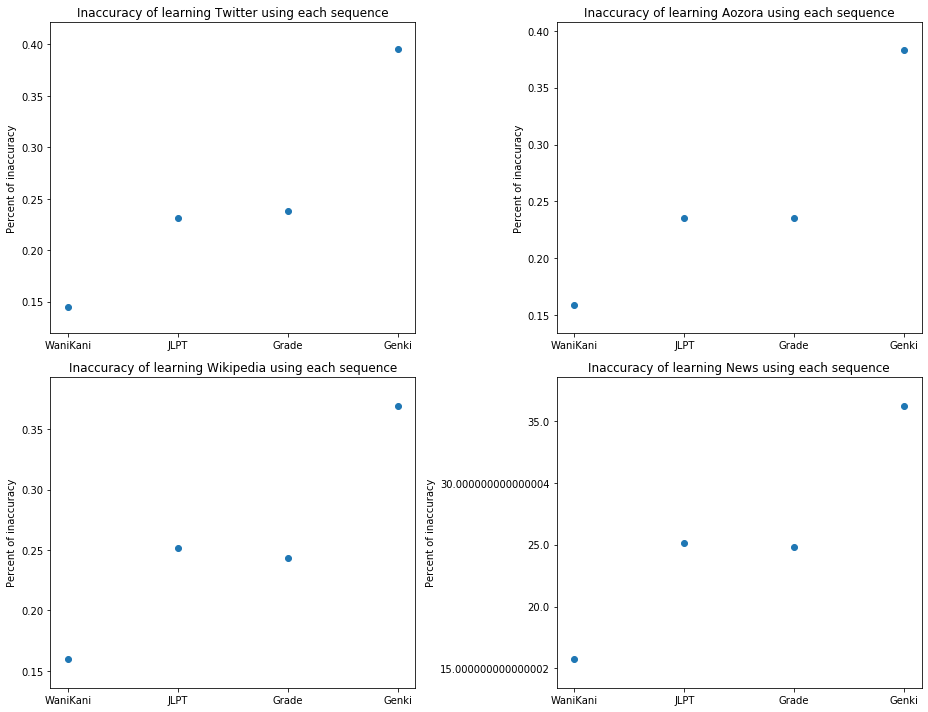

In [16]:
#https://stackoverflow.com/a/43348337
import matplotlib.ticker as ticker
#Currently this xaxis function is unused, doesn't work for scatter plot or something. 
#Turn the x axis into names of sources
def formatterX(x, pos):
    #The name of the data source
    return results[x][2]
#Translate 0.0 to 1.0 to 0.0 to 100.0
#Long floating points is an issue. 
#Maybe force the y axis to use nice round numbers? 0, 10, 20...
#    Maybe we won't end up using this type of chart though. 
def formatterY(y, pos):
    return y*100

fig = plt.figure(figsize=(13,10))

dataX = [i for i in range(0, len(results))]
dataY = []
for source in datasources:
    dataYPiece = [val for val in result_df.loc[source]]
    dataY.append(dataYPiece)
sequence_names = [val[2] for val in results]
#Only need colors if I show them all on the same vertical line. 
#colors = ["black", "blue", "red", "green"]
#correspondingColors = [colors[0] for i in range(1, 4*4+1)]
for ax_index in range(0, len(datasources)):
    ax = fig.add_subplot(2, 2, ax_index+1)
    ax.scatter(dataX, dataY[ax_index])
    props = {    
        #Inaccuracy is a strange word to use here. If there were 4 levels and it was 
        #    all off by 1 it'd be 25% "inaccuracy," right (should probably develop better tests, hard to 
        #    verify these large calculations)? So more, the average difference in level.
        'title': 'Inaccuracy of learning '+datasources[ax_index]+' using each sequence',
        'ylabel': 'Percent of inaccuracy'
    }
    ax.set(**props)
    plt.xticks(range(len(results)), sequence_names, size='medium')
#plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(formatterX))#Doesn't work for scatter plot?
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(formatterY))

#fig.subplots_adjust(wspace=0, hspace=0)
#Prevent overlap
fig.tight_layout()

None

For each source, we have considered the learning sequences from: 
WaniKani
JLPT
Grade
Genki
An inaccuracy of 0 would mean that the order it's taught perfectly corresponds to the frequency of usage


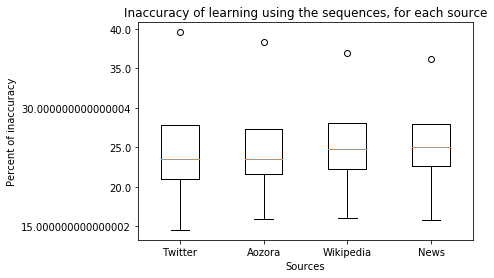

In [17]:
#https://stackoverflow.com/a/43348337
import matplotlib.ticker as ticker
#Turn the x axis into names of sources
def formatterX(x, pos):
    if(x >= 1 and x <= 4):
        return datasources[x-1]
    #This shouldn't occur. Maybe print a warning but it'd be pretty noticeable. 
    return x
#Translate 0.0 to 1.0 to 0.0 to 100.0
#Long floating points is an issue. 
#Maybe force the y axis to use nice round numbers? 0, 10, 20...
#    Maybe we won't end up using this type of chart though. 
def formatterY(y, pos):
    return y*100

fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
ax1.boxplot(percent_results_of_each_source)
props = {    
    #Inaccuracy is a strange word to use here. If there were 4 levels and it was 
    #    all off by 1 it'd be 25% "inaccuracy," right (should probably develop better tests, hard to 
    #    verify these large calculations)? So more, the average difference in level.
    'title': 'Inaccuracy of learning using the sequences, for each source',
    'xlabel': 'Sources',
    'ylabel': 'Percent of inaccuracy'
}
ax1.set(**props)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(formatterX))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(formatterY))
print("For each source, we have considered the learning sequences from: ")
for result in results:
    print(result[2])
print("An inaccuracy of 0 would mean that the order it's taught perfectly corresponds to the frequency of usage")
#TODO can I draw additional conclusions from this? Maybe certain sources have more variety, etc. 
#    But I can get that from the frequency numbers and I'm not sure how useful that'd be to know. 

In [18]:
#TODO remove this, I have this in a dataframe now. 
#Print the values for each source
i=0
for source in datasources:
    print(source, percent_results_of_each_source[i])
    i += 1

Twitter [0.14522003034901365, 0.23180428134556577, 0.23840837415285512, 0.39556962025316456]
Aozora [0.15872534142640363, 0.23574338085539717, 0.23525864379522915, 0.38276069921639544]
Wikipedia [0.15977069634125782, 0.25132382892057026, 0.2436738519212746, 0.3693490054249548]
News [0.15787388298769178, 0.25137614678899084, 0.24810618757122746, 0.36196503918022904]


In [19]:
#We could also store this in a csv at this point. 

Also lets do the queries Oleksandra wanted:
    
Given a user has completed a level of WaniKani, Grade level, Genki, or JLPT, what are the most frequent kanji in the next level of that system? For frequency we're just using Jisho's frequency numbers. 

In [20]:
#Sequence is what you're learning, like jlpt or Genki_Lessons or wanikani_Level
#Translator translates that sequence's levels like "N1" into number ranks.
#numberToGet is how many kanji from the next level to return
def getNextInSquence(sequence, level, translator, numberToGet):
    col = zip(df["kanji"], df[sequence])
    
    colAboveLevel = []
    previouslyCompletedLevel = translator(level)
    #The column is now created by index, and the index is from Joyo. 
    for (kanji, levelInSequence) in col:
        numericLevelInSequence = translator(levelInSequence)
        #If you wanted to retrieve data from the current or any hight level, just make this >=
        if(numericLevelInSequence > previouslyCompletedLevel):
            colAboveLevel.append((kanji, levelInSequence, numericLevelInSequence))
    #Now we sort by the numeric level (Can't sort by string level, N1 is harder than N2), 
    #    so that we give them the next hardest kanji instead of any harder kanji. 
    colAboveLevel.sort(key=lambda tup: tup[2])
    #If you want to sort the kanji in each level by some other column, such as Jisho's frequency:
    sortedCol = []
    nextLowestLevel = -1
    for (kanji, level, numericLevelInSequence) in colAboveLevel:
        pass
        #We want to keep stuff sorted by difficulty level as well, not only the frequency
        #I suppose we could maybe remove harder levels from the data, 
        #    but that would be a problem if we're requesting more kanji than are in the next level. 
        #Maybe split it up into pieces by level and sort within each of those pieces by frequency?
        #TODO add more logic
        #if(nextLowestLevel == -1 or something):
        #    nextLowestLevel = numericLevelInSequence
        #while(nextLowestLevel == numericLevelInSequence):
        #TODO add more logic
        #sortedCol.append((kanji, level, numericLevelInSequence))
    #return sortedCol
    
    return colAboveLevel[:numberToGet]
        
def getMoreWani(level, numberToGet):
    #Actual col name in the dataframe
    sequence = "wanikani_level"
    #Values in the dataframe may not be ints, so the translator is required. 
    #But for WaniKani, it is just ints
    translator = intIsJustItself
    return getNextInSquence(sequence, level, translator, numberToGet)
def getMoreGrade(level, numberToGet):
    #Actual col name in the dataframe
    sequence = "grade"
    #Values in the dataframe may not be ints, so the translator is required. 
    translator = translateGradeLevel
    return getNextInSquence(sequence, level, translator, numberToGet)
def getMoreJLPT(level, numberToGet):
    #Actual col name in the dataframe
    sequence = "jlpt"
    #Values in the dataframe may not be ints, so the translator is required. 
    translator = translateJLPT
    return getNextInSquence(sequence, level, translator, numberToGet)
def getMoreGenki(level, numberToGet):
    #Actual col name in the dataframe
    sequence = "Genki_Lesson"
    #Values in the dataframe may not be ints, so the translator is required. 
    translator = translateGenki
    return getNextInSquence(sequence, level, translator, numberToGet)

#Takes the name of the sequence you're learning, the level you last completed, and how many kanji you want to get.
#Returns a tuple: (kanji, level string, level number)
def getMore(sequenceName, lastCompletedLevel, numberToGet):
    if(numberToGet <= 0):
        return []
    sequenceName = sequenceName.lower()
    if(sequenceName == "wanikani"):
        return getMoreWani(lastCompletedLevel, numberToGet)
    if(sequenceName == "grade" or sequenceName == "grade level"):
        return getMoreGrade(lastCompletedLevel, numberToGet)
    if(sequenceName == "jlpt"):
        return getMoreJLPT(lastCompletedLevel, numberToGet)
    if(sequenceName == "genki"):
        return getMoreGenki(lastCompletedLevel, numberToGet)
    raise ValueError('No sequence found with name '+sequenceName)

For all of these queries you are saying the level you last completed, and getting stuff from the next level. 

The results are currently unsorted apart from level (if the next level contains 40 kanjis and you request 50, you'll get 40 from the next level and 10 unsorted from the level above that).

To retrieve kanji starting at the first level, for the previously completed level pass in 0 for numeric levels, or the string "none" for string-based levels.

Giving the final level or invalid input, the result should be empty. 

(TODO) Also add warnings/exceptions

In [21]:
mostRecentlyCompletedLevel = 50
numberToGet = 3
print(getMore("WaniKani", mostRecentlyCompletedLevel, numberToGet))
#Should give results from the first level since this is from before the first level
print(getMore("WaniKani", 0, numberToGet))
#Should give nothing
print(getMore("WaniKani", 60, numberToGet))

[('偉', 51.0, 51.0), ('浦', 51.0, 51.0), ('媛', 51.0, 51.0)]
[('一', 1.0, 1.0), ('下', 1.0, 1.0), ('九', 1.0, 1.0)]
[]


In [22]:
mostRecentlyCompletedLevel = "grade 6"
print(getMore("grade", mostRecentlyCompletedLevel, numberToGet))
#Additional tests.
print(getMore("grade", "none", numberToGet))
print(getMore("grade", "junior high", numberToGet))

[('亜', 'junior high', 7), ('哀', 'junior high', 7), ('挨', 'junior high', 7)]
[('一', 'grade 1', 1), ('右', 'grade 1', 1), ('雨', 'grade 1', 1)]
[]


In [23]:
mostRecentlyCompletedLevel = "N3"
print(getMore("jlpt", mostRecentlyCompletedLevel, numberToGet))
#Additional tests.
print(getMore("jlpt", "none", numberToGet))
print(getMore("jlpt", "N1", numberToGet))

[('圧', 'N2', 4), ('衣', 'N2', 4), ('囲', 'N2', 4)]
[('一', 'N5', 1), ('右', 'N5', 1), ('雨', 'N5', 1)]
[]


In [24]:
mostRecentlyCompletedLevel = 10
print(getMore("genki", mostRecentlyCompletedLevel, numberToGet))
#Additional tests.
#The level information we have starts at 3, so 2 or lower should be invalid and give the fist stuff (3).
print(getMore("genki", 1, numberToGet))
print(getMore("genki", 24, numberToGet))

[('院', 11.0, 9.0), ('映', 11.0, 9.0), ('歌', 11.0, 9.0)]
[('一', 3.0, 1.0), ('円', 3.0, 1.0), ('九', 3.0, 1.0)]
[]


In [25]:
#Tests for invalid input

#Test with a nonexistant sequence, raises exception
#print(getMore("badvalue", 1, numberToGet))
#Test with a nonexistant numeric level? Just gives first level if small, empty [] if large
#print(getMore("genki", -1, numberToGet))
#Test with a nonexistant string level. Just gives []
#print(getMore("jlpt", "level name", numberToGet))
#Test with invalid numberToGet, gives []
#print(getMore("genki", 1, -5))

In [26]:
#This question also was originally written to ask for vocab. 
#Questions 1 & 2 contain information about readings and words with a given kanji, 
#    so whatever information is desired can be retrieved from there after using these queries.  